In [12]:
import matplotlib.pyplot as plt
import exoplanet as xo
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import corner
import pickle
import sys

sys.path.append("../../codes/")
sys.path.append("../../plotutils/")
import utils
import plotutils
import arviz
%autoreload 2

In [3]:
# Plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("default")

## The transit model in PyMC3

In this example, we will examine the convergence of a simple two-planet transit model fit to simulated data. We will use the [`exoplanet`](https://exoplanet.dfm.io/en/stable/) package to create this data and perform the sampling. To start, let's randomly sample some orbital periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2) # Orbital period of each planet in days
t0s = periods * np.random.rand(2) # Orbital phase
t = np.arange(0, 80, 0.02) # Span of timeseries
yerr = 5e-4 # Measured flux error

Next, we'll define the transit model with the following parameters (11 total):

- baseline flux $(mean)$
- phase $(t_0)$, one for each planet
- period $(P)$, one for each planet
- two-parameter limb darkening re-parameterization of the star $(u)$ [Kipping (2013)](https://arxiv.org/abs/1308.0009)
- planet-to-star radius ratio $(r)$, one for each planet
- impact parameter $(b)$, one for each planet

In [5]:
with pm.Model() as model:
    # Baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # Time of a reference transit for each planet (phase)
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # Log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # Kipping (2013) parameterization for quadratic limb darkening parameters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    # Planet-to-star radius ratio
    r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2, 
                   testval=np.array([0.04, 0.06]))
    b = xo.distributions.ImpactParameter("b", ror=r, shape=2,
                                         testval=np.random.rand(2))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting purposes
    pm.Deterministic("light_curves", light_curves)

    # Simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    map_soln = xo.optimize(start=model.test_point)

/Users/mango/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/mango/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]/Users/mango/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequenc

The graphical representation for this model is shown below:

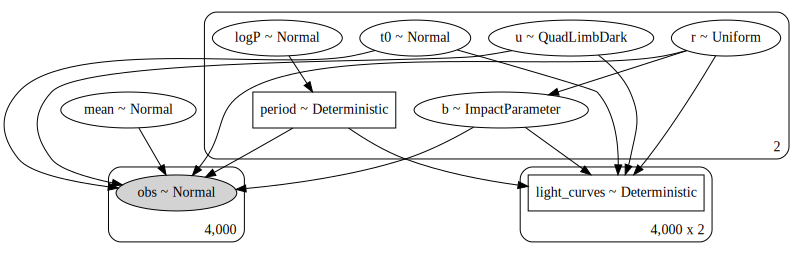

In [16]:
pm.model_to_graphviz(model)

In [5]:
# Save MAP solution to disk for quick access
np.save("data/map_solution.npy", map_soln)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

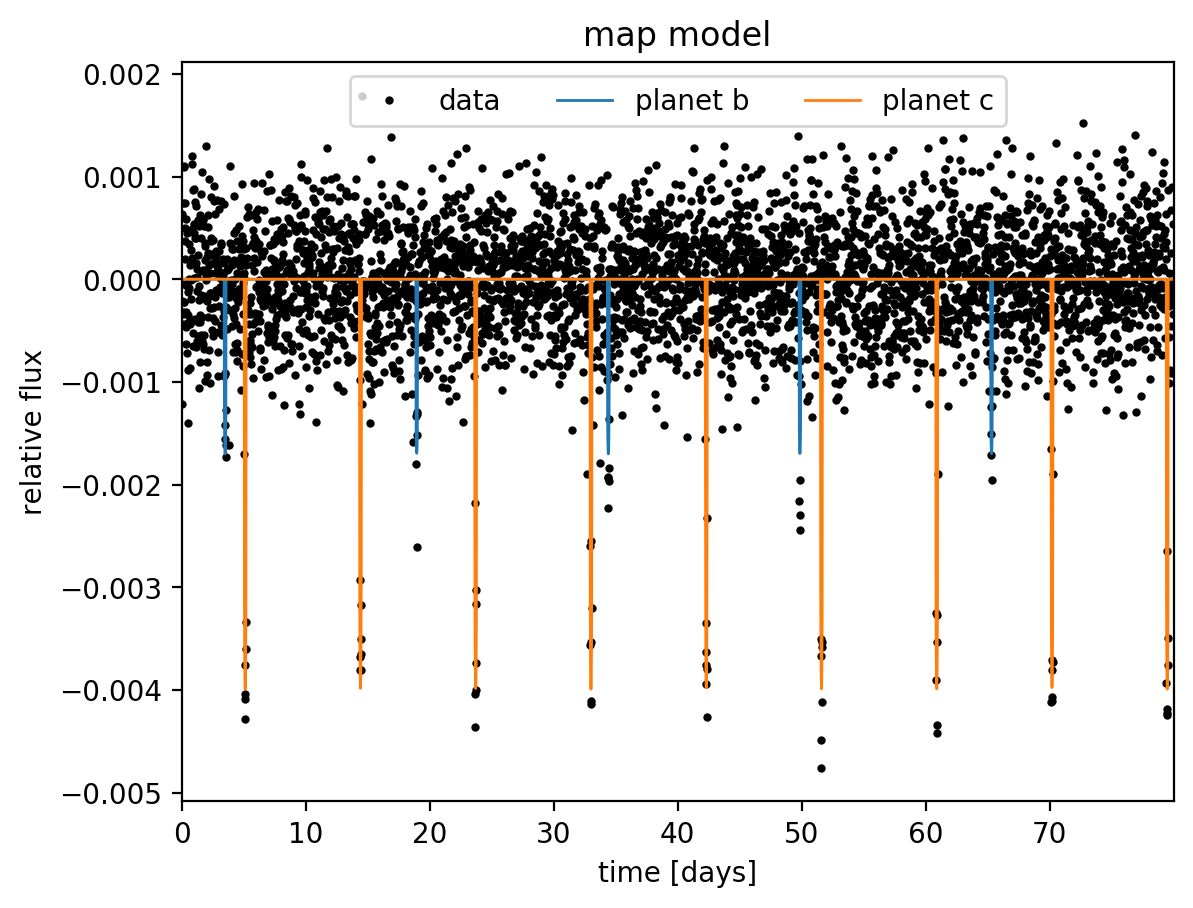

In [6]:
map_soln = np.load("data/map_solution.npy", allow_pickle=True).item()
plt.plot(t, y, "k.", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(loc="upper center", ncol=3)
plt.title("map model");

We can see two separate orbits emerging from the timeseries data. Next we will fit the model using the above MAP estimate as an initial guess for our sampler.

## Sampling

Typically there are strong covariances between some of the parameters, so we'll use a dense NUTS sampler:

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/Users/mango/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, r, u, logP, t0, mean]
/Users/mango/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 24000/24000 [01:58<00:00, 203.31draws/s]


In [8]:
# Save model and trace to disk for quick access
with open("data/trace.pkl", "wb") as buff:
    pickle.dump({"model": model, "trace": trace}, buff)

$\newcommand{\rhat}{\widehat R}$
Let's take a quick look at the corresponding values of the standard $\rhat$ computed by `pymc3` for the combined chains:

In [9]:
# load trace
with open("data/trace.pkl", "rb") as buff:
    data = pickle.load(buff)  
model, trace = data["model"], data["trace"]

params = ["mean", "t0", "period", 'u', 'r', 'b']
pm.summary(trace, varnames=params)

/Users/mango/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd      mc_error    hpd_2.5   hpd_97.5  \
mean        0.000004  0.000008  6.478417e-08  -0.000011   0.000020   
t0__0       3.502992  0.005734  8.364260e-05   3.492303   3.514489   
t0__1       5.121266  0.001345  1.226780e-05   5.118663   5.123948   
period__0  15.447951  0.002307  3.450422e-05  15.442994  15.451919   
period__1   9.292480  0.000297  2.898916e-06   9.291909   9.293036   
u__0        0.373473  0.208282  2.264336e-03   0.000095   0.730987   
u__1        0.276961  0.343886  5.011025e-03  -0.336070   0.863000   
r__0        0.039579  0.001588  2.221729e-05   0.036340   0.042479   
r__1        0.058478  0.001045  1.566980e-05   0.056442   0.060400   
b__0        0.669806  0.047084  8.904896e-04   0.569223   0.739345   
b__1        0.402861  0.037899  5.733628e-04   0.327062   0.467703   

                  n_eff      Rhat  
mean       14655.667033  0.999872  
t0__0       4494.572790  1.000130  
t0__1      13063.885126  1.000193  
period__0   4293.214505  1.000464  
period__1  10236.566543  1.000309  
u__0        8429.341310  1.000615  
u__1        4861.322395  1.001205  
r__0        5342.926998  1.000482  
r__1        4450.867425  1.000764  
b__0        3125.219287  1.000947  
b__1        4439.786444  1.001223

We used a fairly robust sampling method, so the standard $\rhat$ values are all within convergence limits, as expected. The associated pair plots of the model parameters for each planet are shown below: 

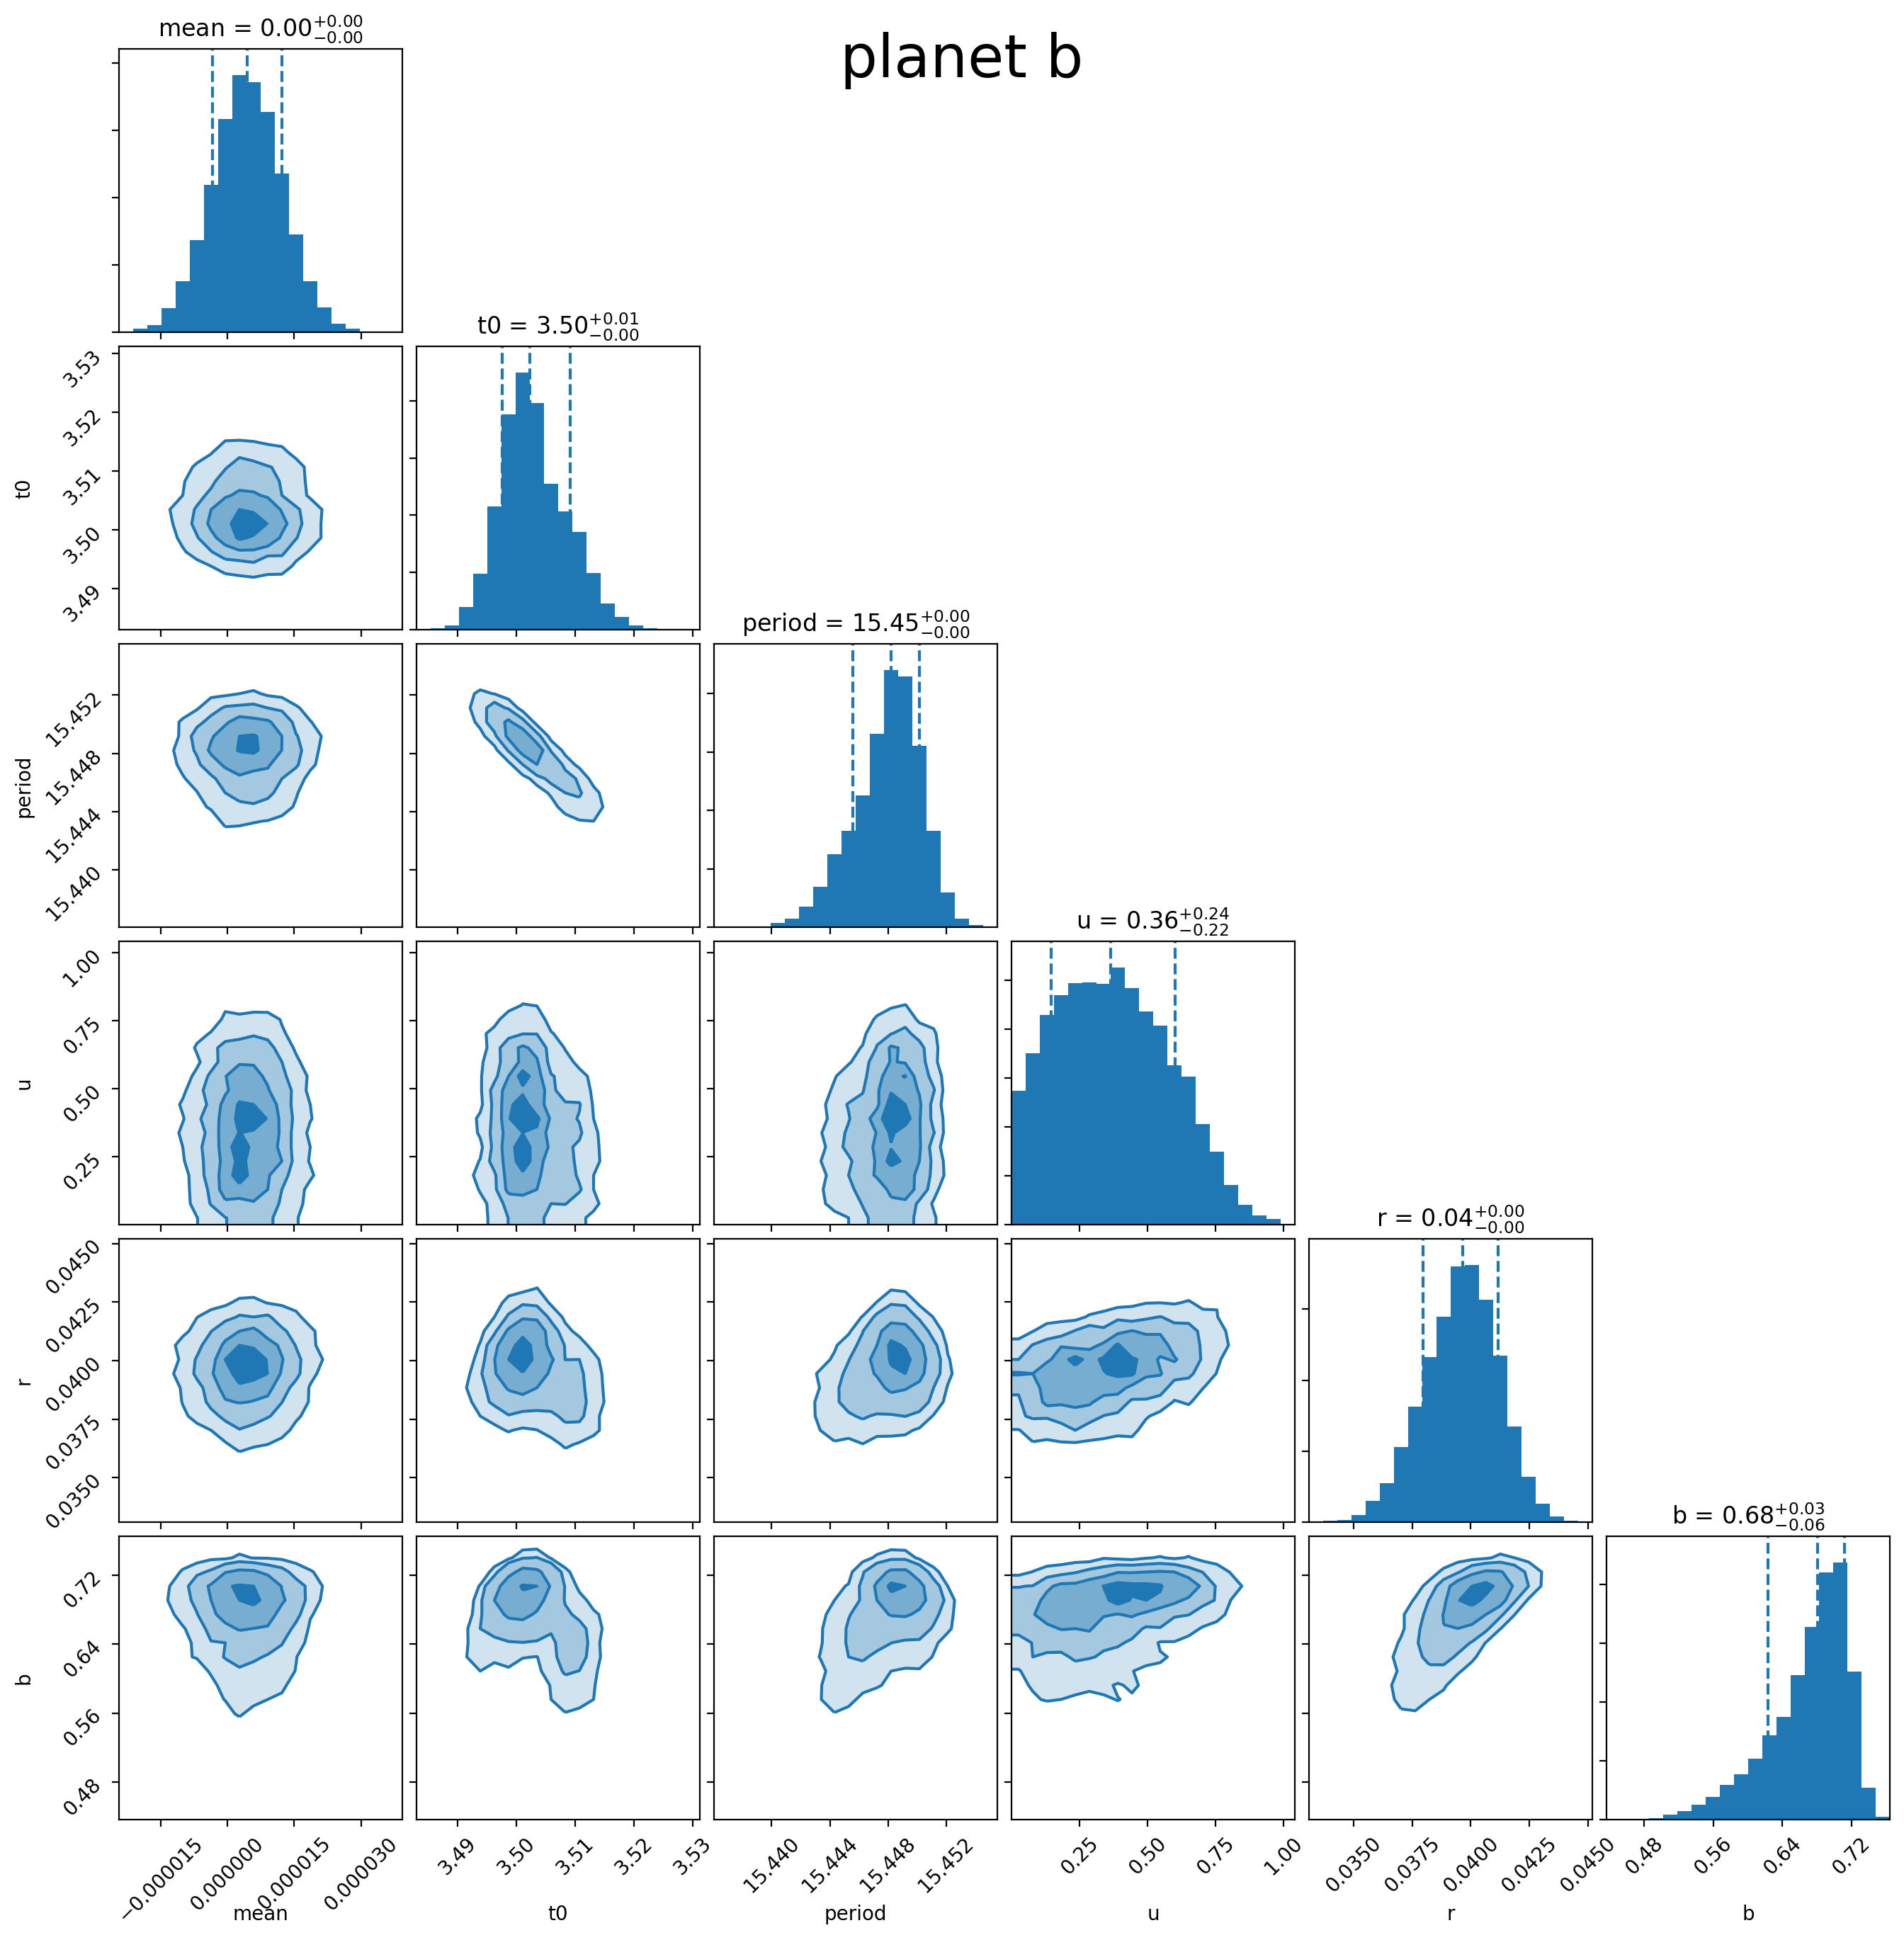

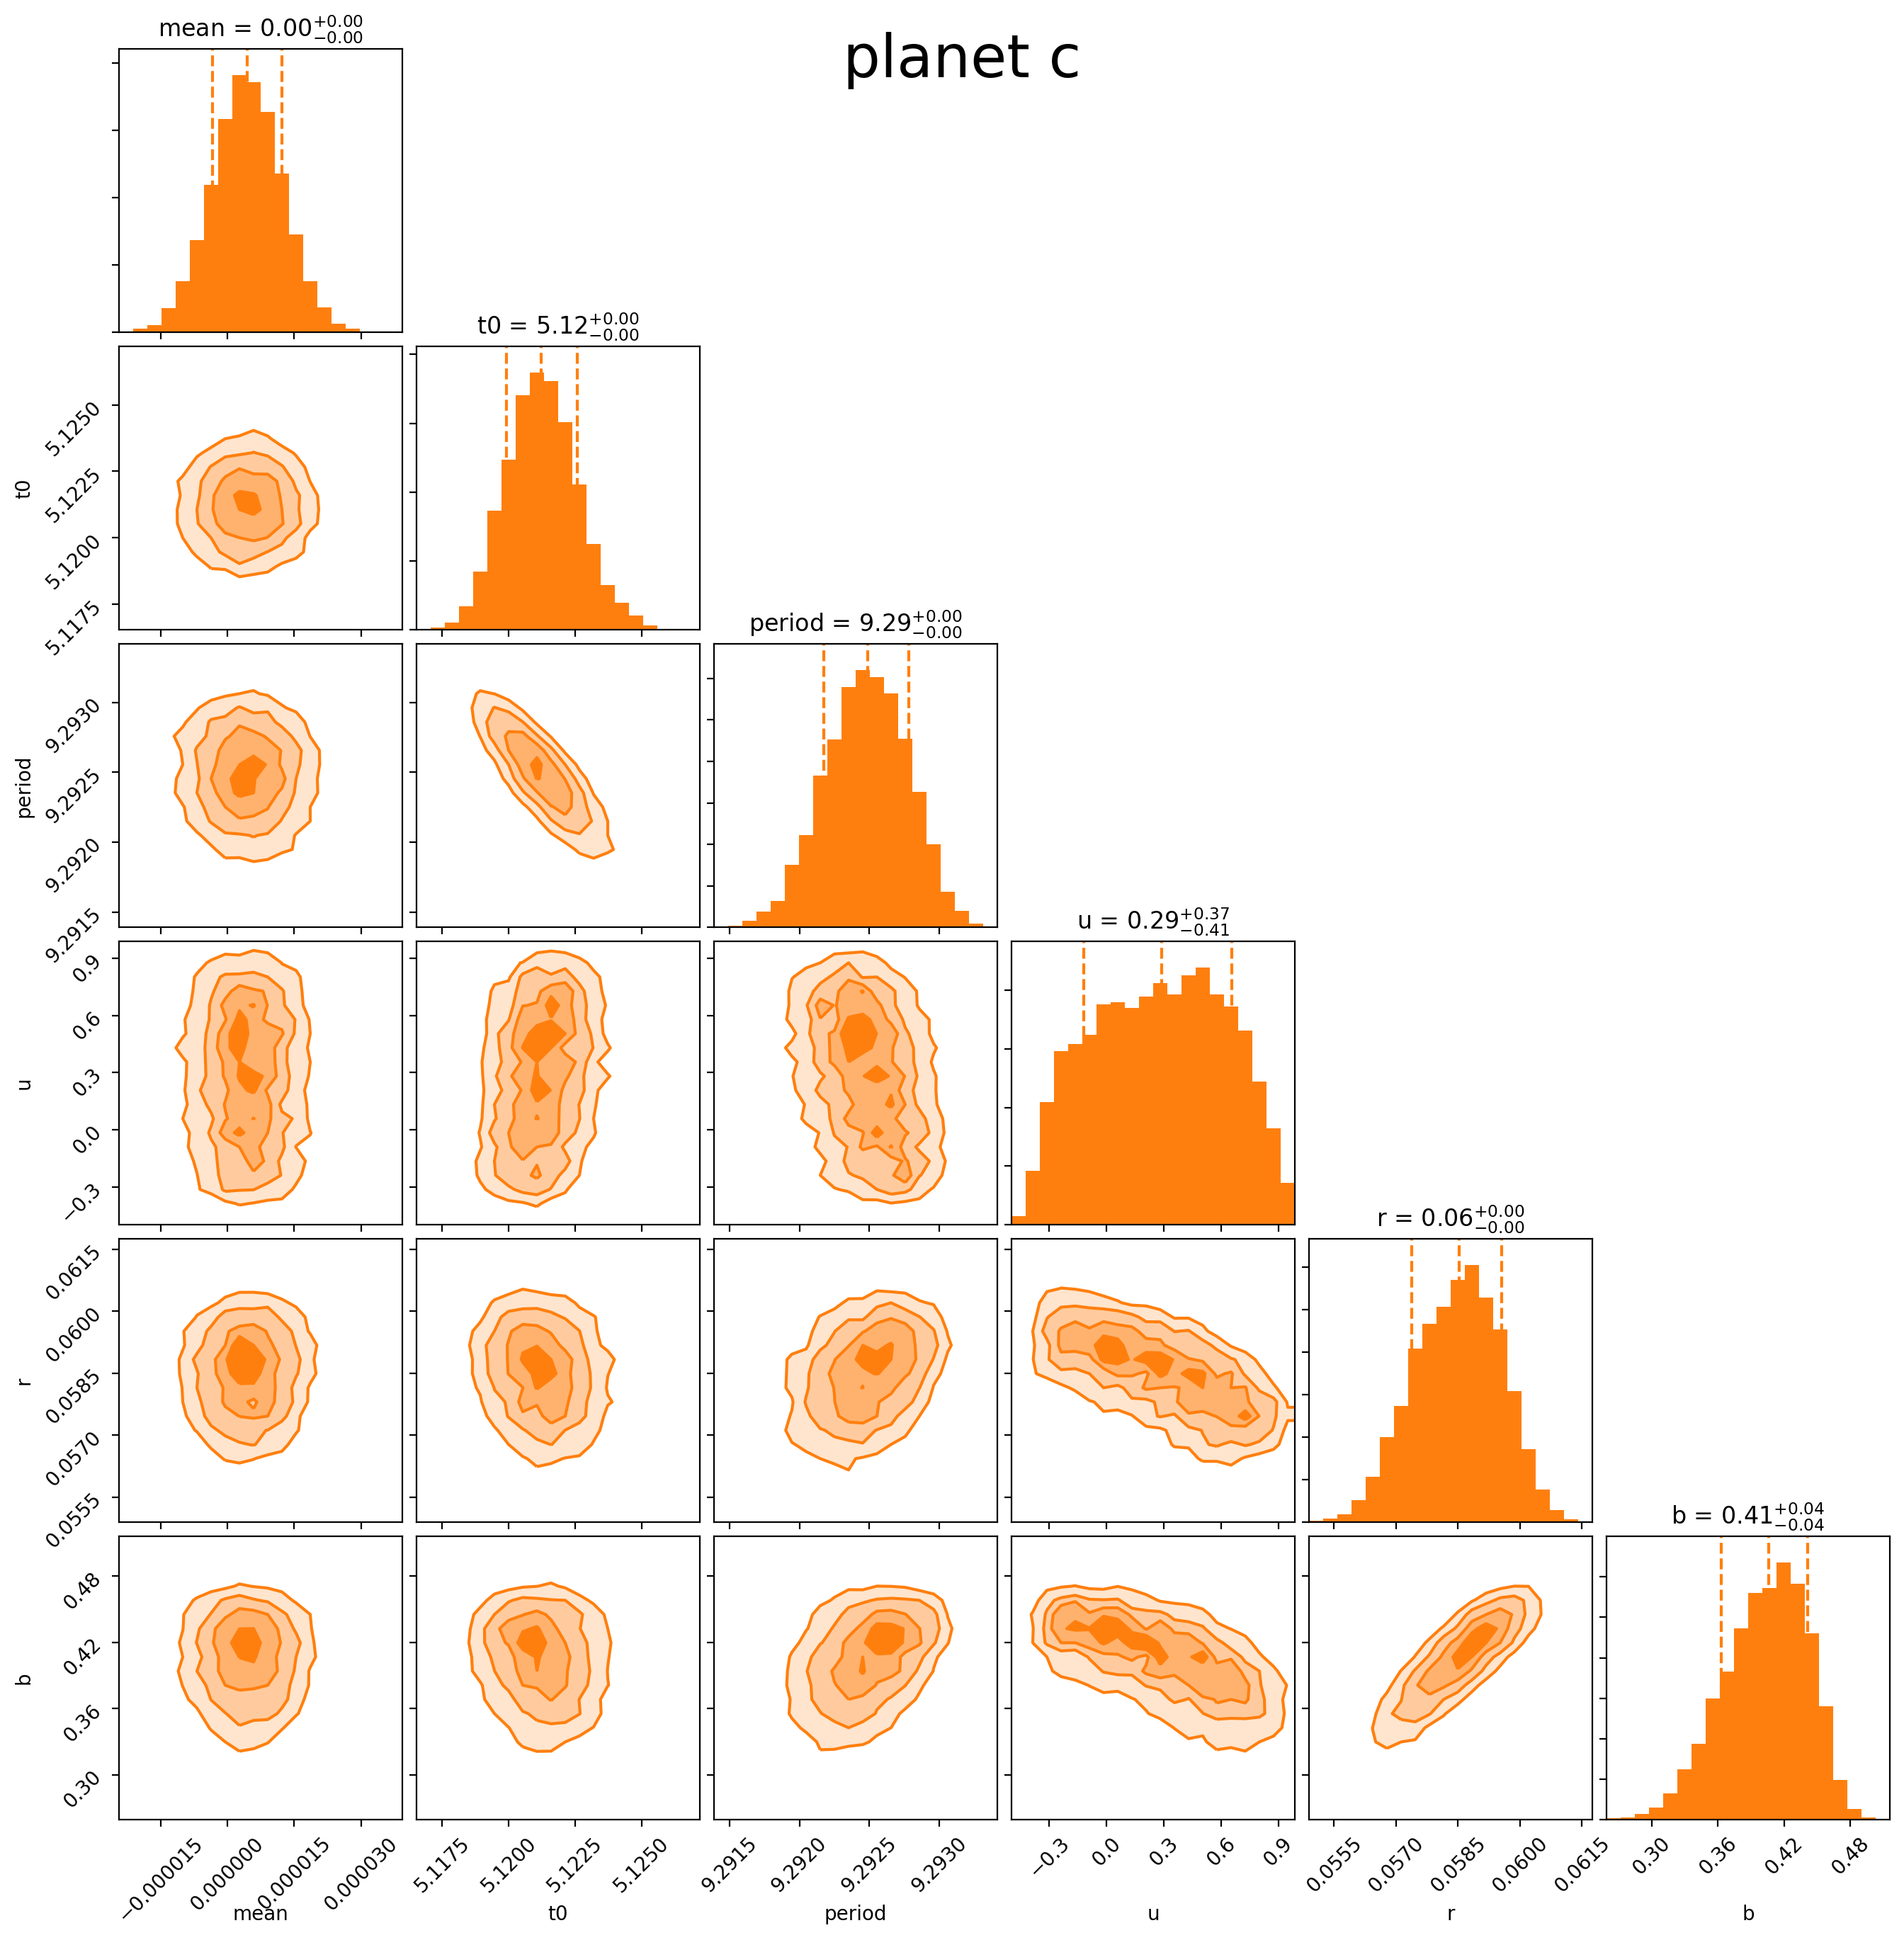

In [10]:
samples = pm.trace_to_dataframe(trace, varnames=params)
params_planet_1 = ["mean"] + [f"{s}__0" for s in params if s != "mean"]
params_planet_2 = ["mean"] + [f"{s}__1" for s in params if s != "mean"]
samples_planet_1 = samples[params_planet_1]
samples_planet_2 = samples[params_planet_2]

# planet 1 corner plot
fig_planet_1 = corner.corner(
    samples_planet_1, labels=params, color='C0', plot_datapoints=False,
    fill_contours=True, show_titles=True, quantiles=(0.16, 0.5, 0.84),
    hist_kwargs={"histtype":"stepfilled"}
)
fig_planet_1.suptitle("planet b", fontsize=30);

# planet 2 corner plot
fig_planet_2 = corner.corner(
    samples_planet_2, labels=params, color='C1', plot_datapoints=False,
    fill_contours=True, show_titles=True, quantiles=(0.16, 0.5, 0.84),
    hist_kwargs={"histtype":"stepfilled"}
)
fig_planet_2.suptitle("planet c", fontsize=30);

Now let's examine the trace of the individual chains for each planet

planet b


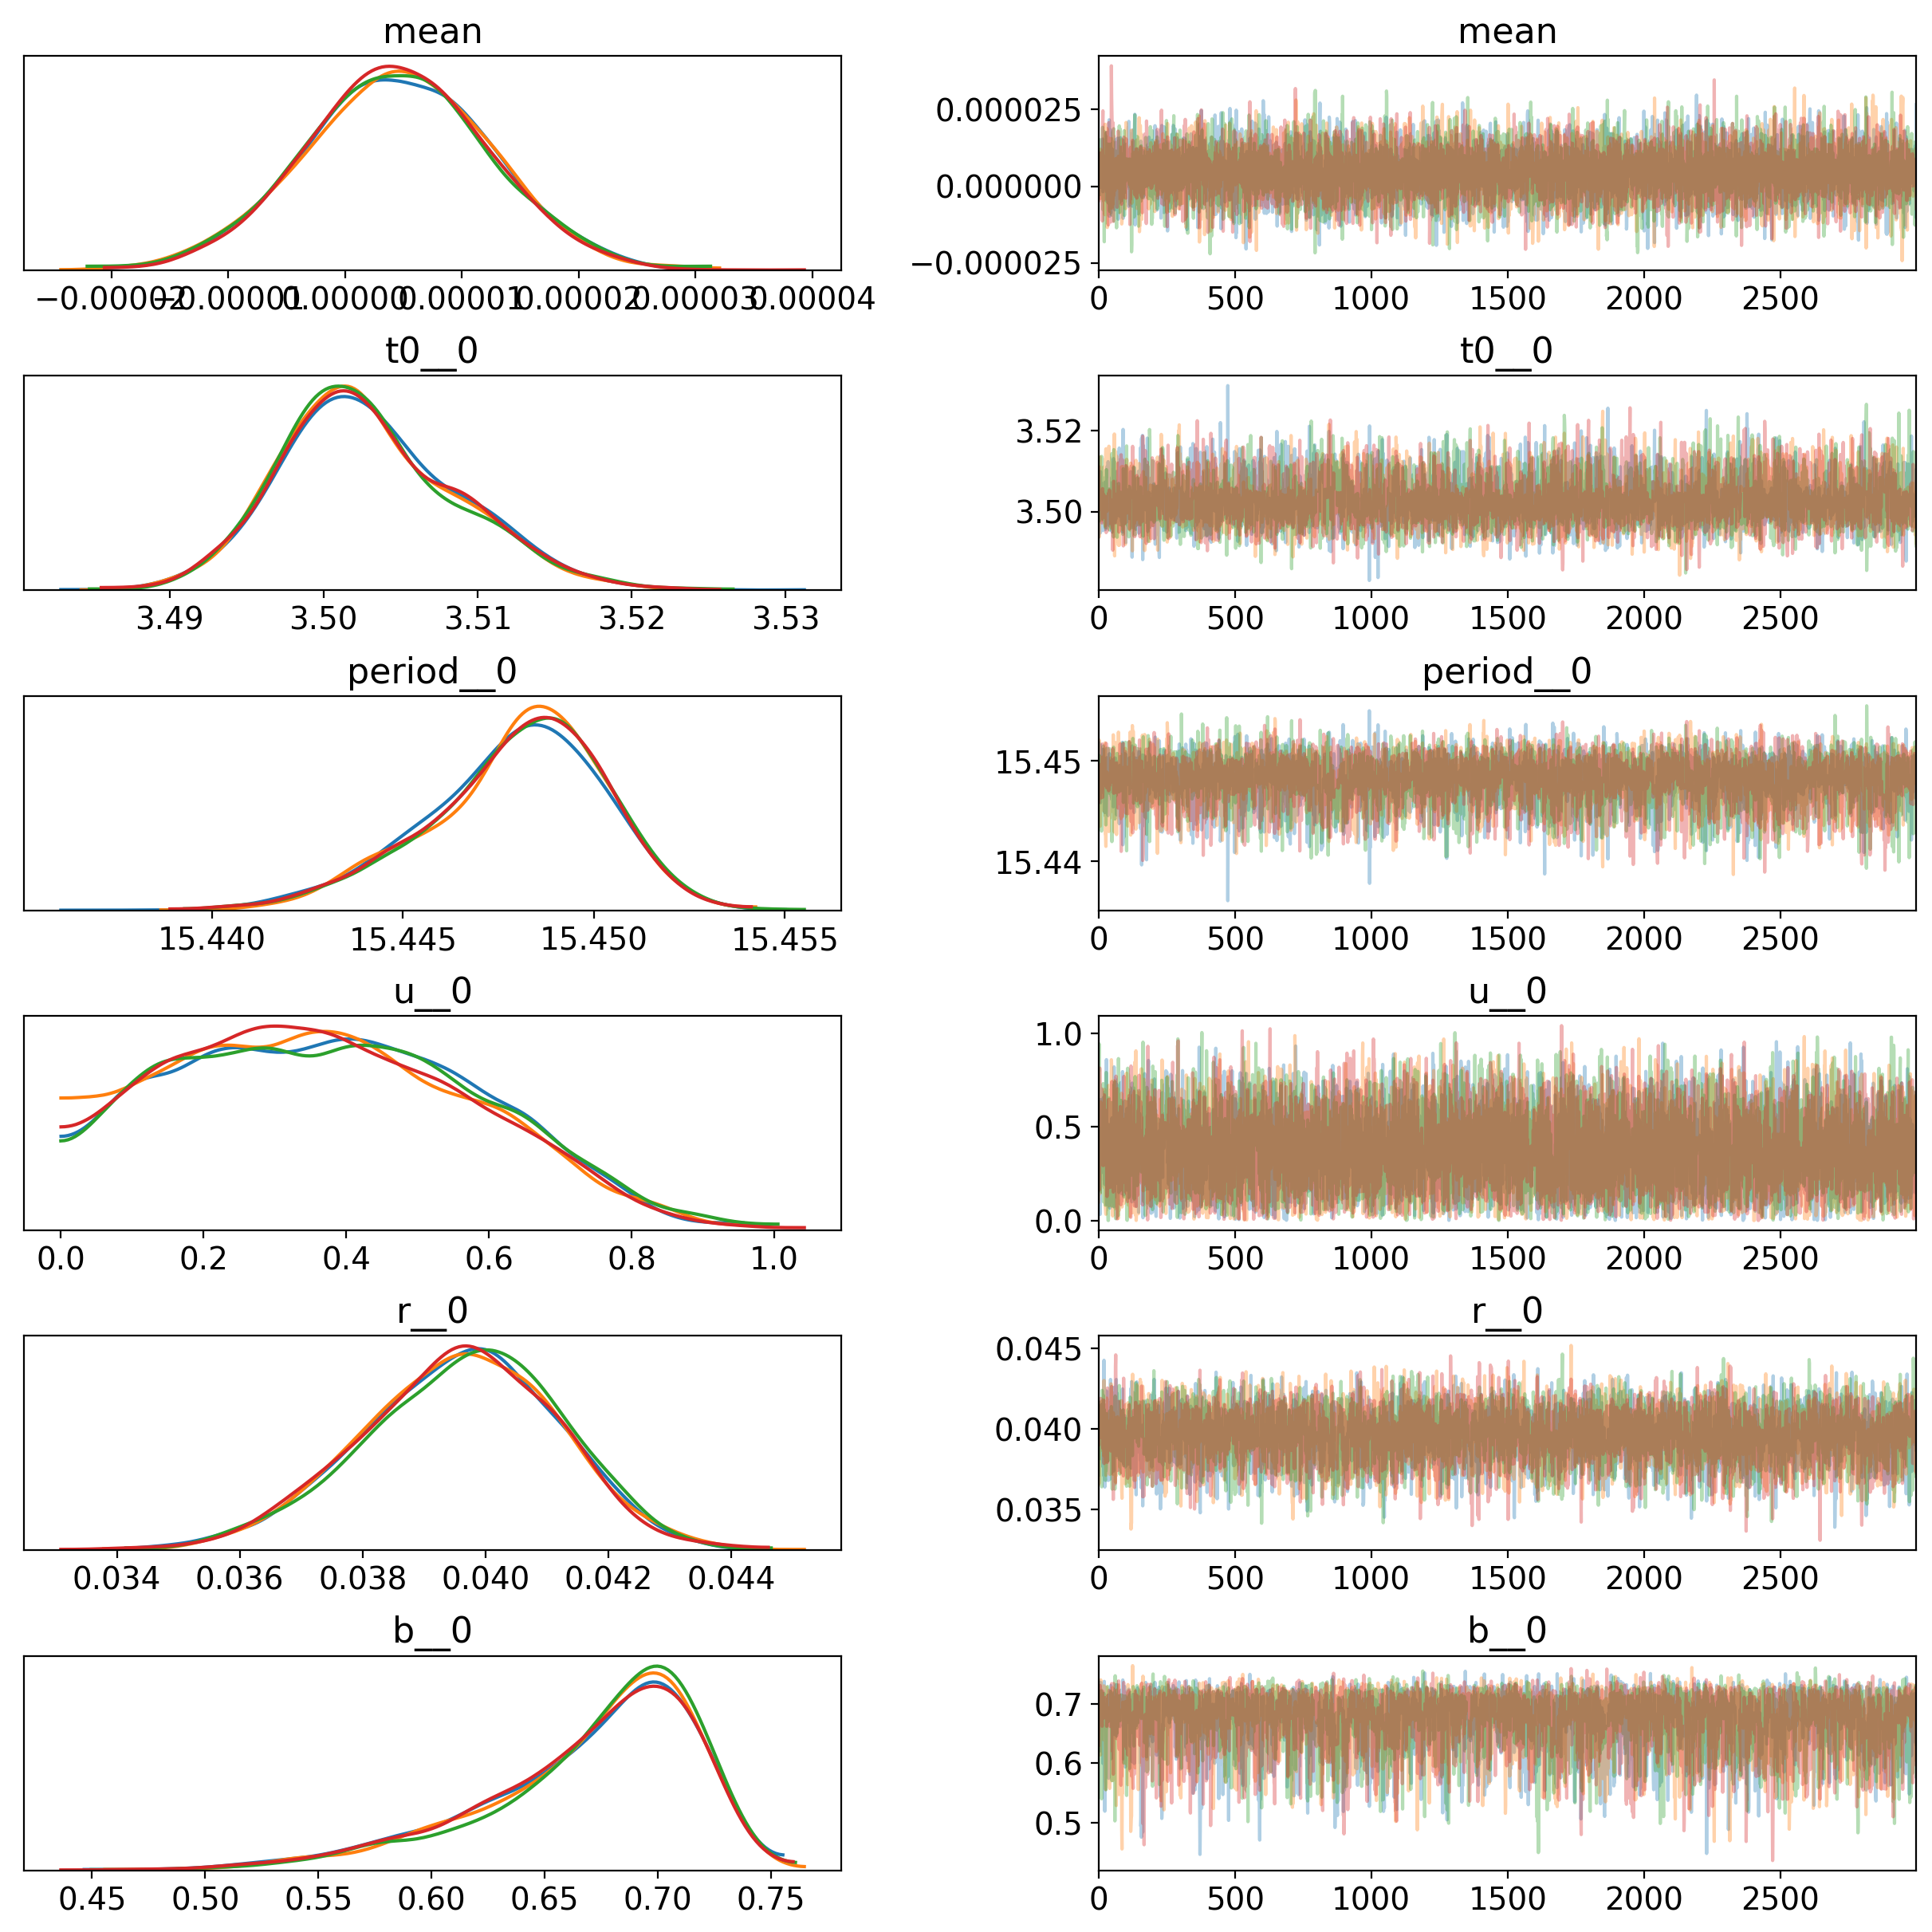

planet c


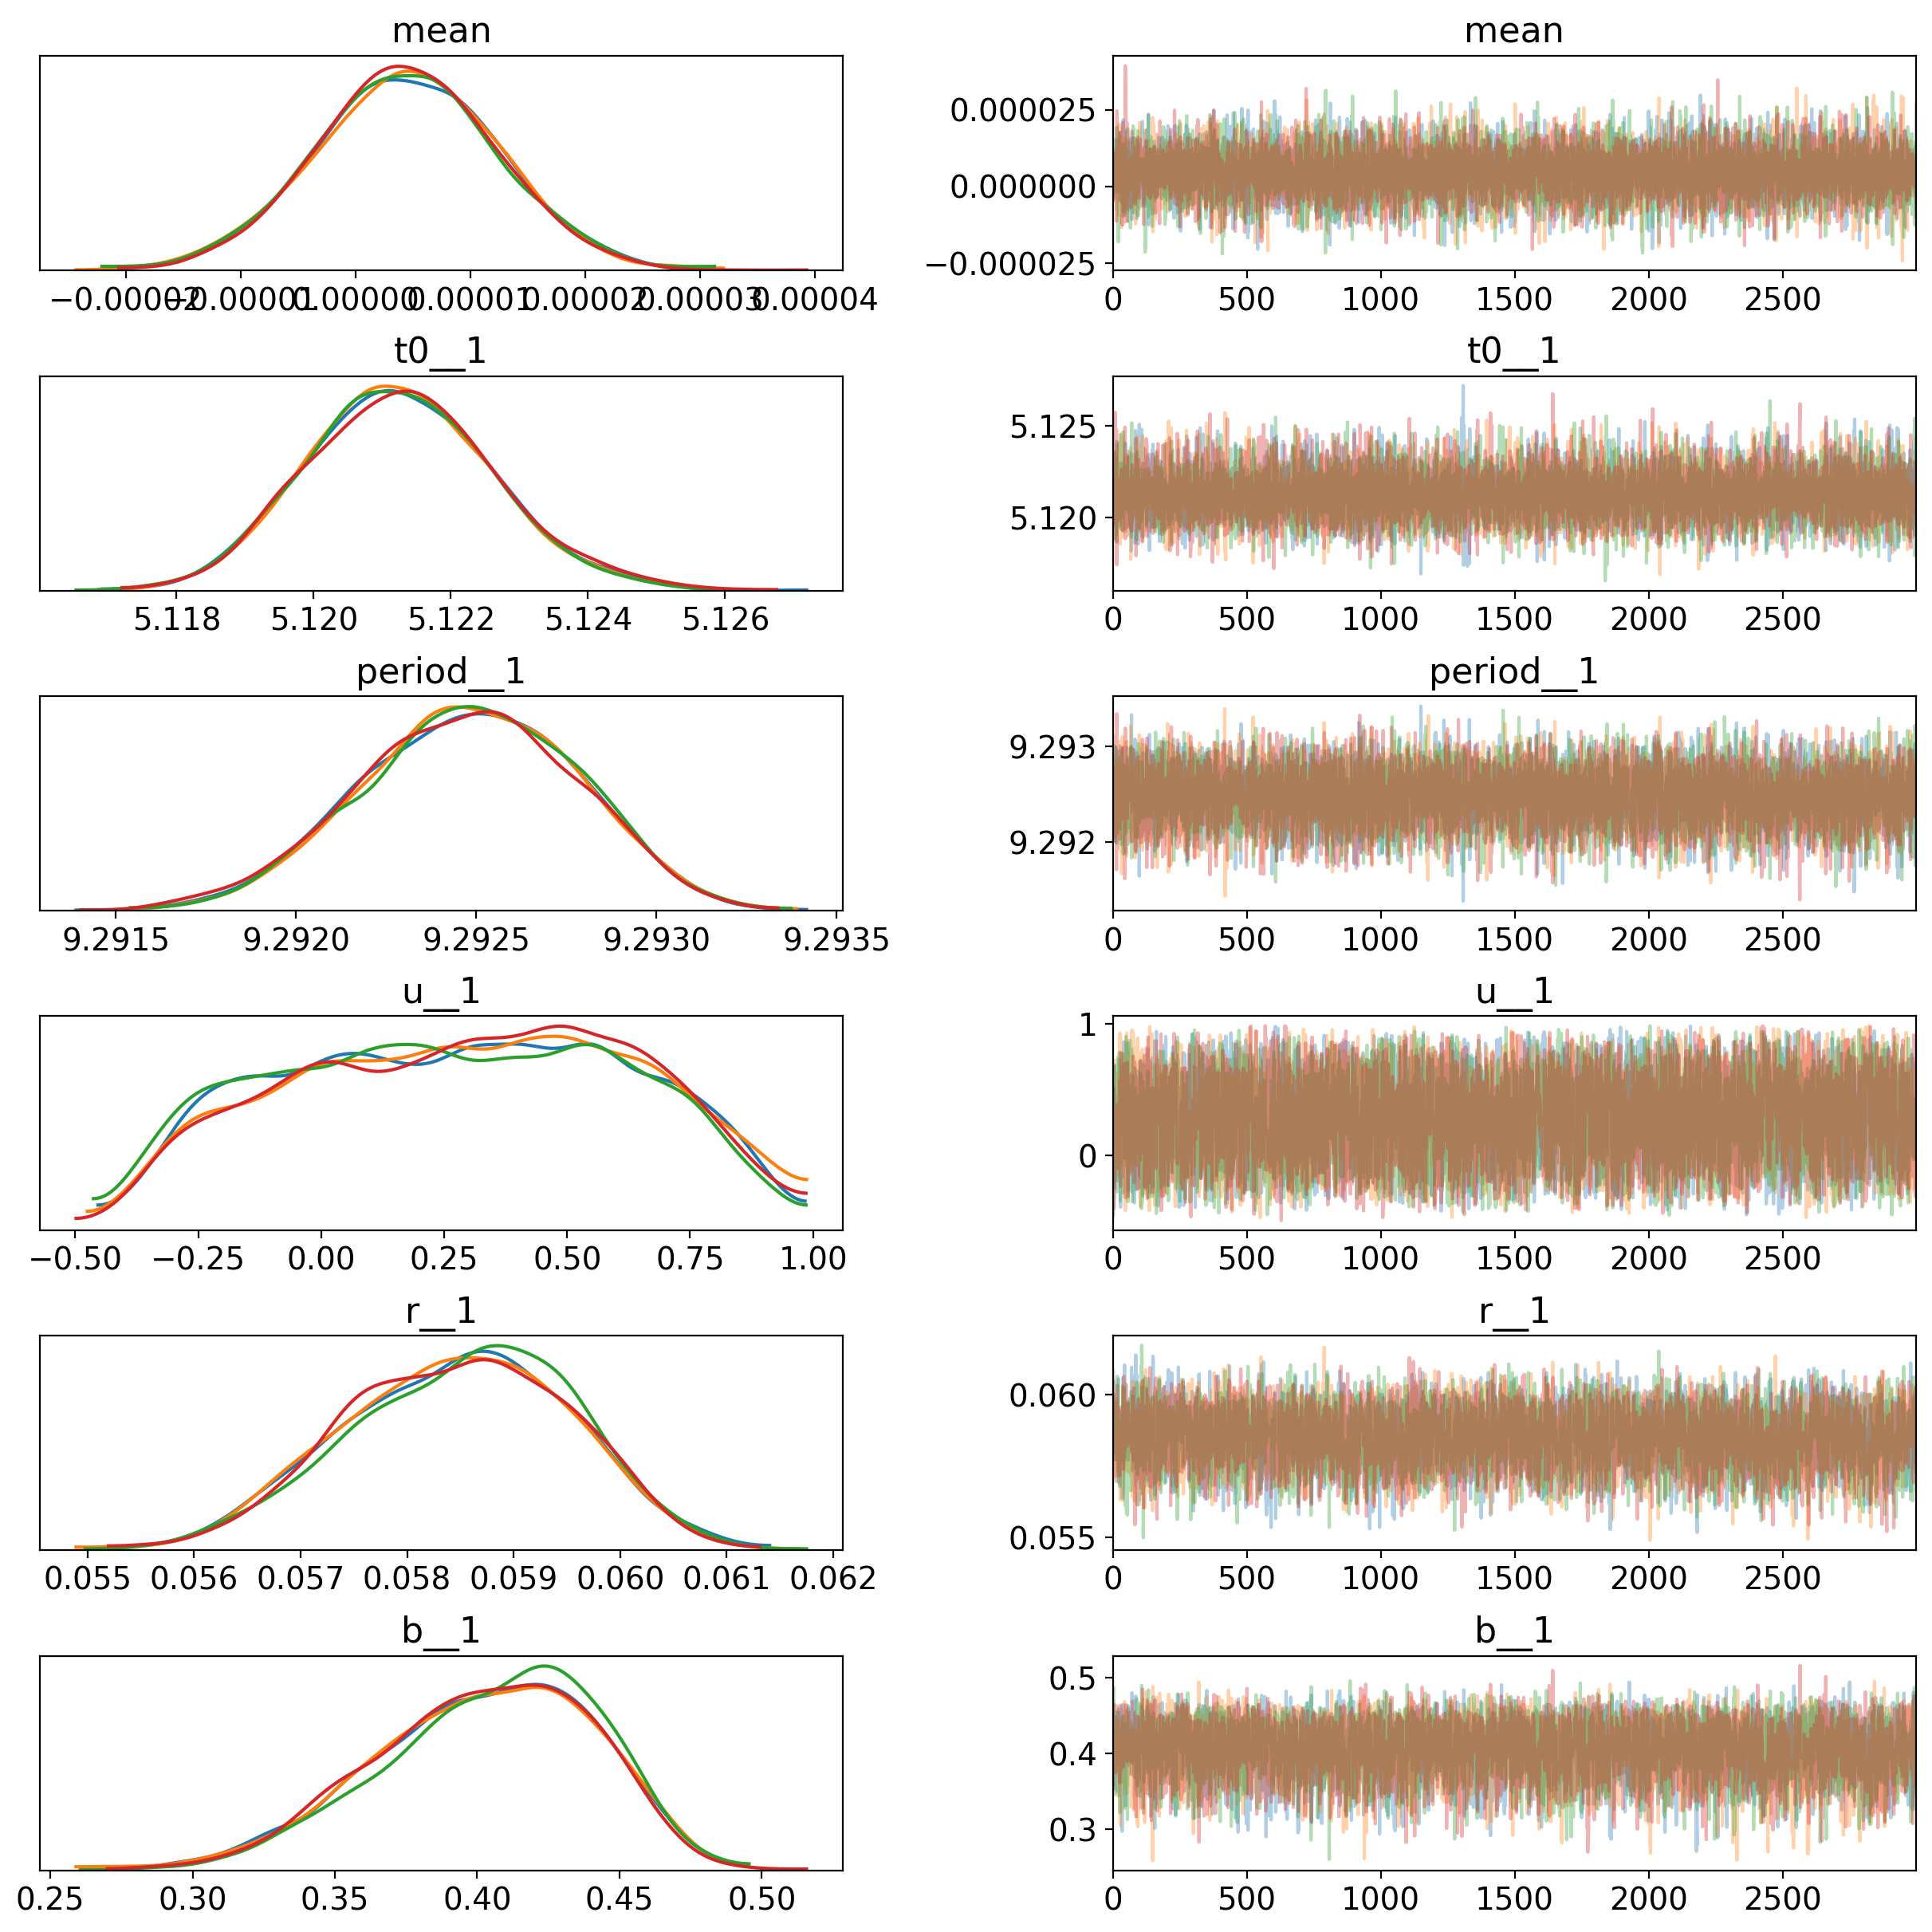

In [11]:
planet_1_mchains = np.split(samples_planet_1, 4) # Separate chains
planet_1_params_dict = {} # Each param entry will hold corresponding mchain array
for param in params_planet_1:
    param_chains = []
    for chain in planet_1_mchains:
        param_chains.append(chain[param])
    
    # Fill in dict
    planet_1_params_dict[param] = np.array(param_chains)

print("planet b")
pm.traceplot(planet_1_params_dict)
plt.show()

planet_2_mchains = np.split(samples_planet_2, 4) # Separate chains
planet_2_params_dict = {} # Each param entry will hold corresponding mchain array
for param in params_planet_2:
    param_chains = []
    for chain in planet_2_mchains:
        param_chains.append(chain[param])
    
    # Fill in dict
    planet_2_params_dict[param] = np.array(param_chains)

print("planet c")
pm.traceplot(planet_2_params_dict)
plt.show()

In [12]:
# Save dataframe for each multi-chain to disk for quick access
for i in trace.chains:
    df_i = pm.trace_to_dataframe(trace, varnames=params, chains=i)
    df_i.to_pickle(f"data/multiplanet_chain_{i+1}.pkl")

The various $\rhat$ values for each parameter is shown below for comparison to the standard $\rhat$ definition.

In [13]:
print("planet b")
display(utils.rhat_results(planet_1_params_dict))
print("planet c")
display(utils.rhat_results(planet_2_params_dict))

planet b


mean     t0__0  period__0      u__0      r__0      b__0
standard  0.999872  1.000130   1.000464  1.000615  1.000482  1.000947
split     0.999801  1.001109   1.001298  1.000703  1.001219  1.002728
ranked    0.999804  1.000937   1.001186  1.000814  1.001228  1.002411
folded    1.000258  1.000619   1.000494  1.000298  0.999870  1.001292

planet c


mean     t0__1  period__1      u__1      r__1      b__1
standard  0.999872  1.000193   1.000309  1.001205  1.000764  1.001223
split     0.999801  1.000011   1.000168  1.001650  1.001558  1.002201
ranked    0.999804  1.000001   1.000168  1.001768  1.001521  1.002035
folded    1.000258  1.000014   0.999902  0.999967  1.000093  1.000256

Across the board, the modified $\rhat$ implementations return a larger value than their standard counterpart. This shows the importance of performing these additional convergence diagnostics instead of relying only on the out-of-the box values.

# Rank Plots

We show the associated rank plots for each parameter below. The chains are all well-mixed as expected.

planet 1


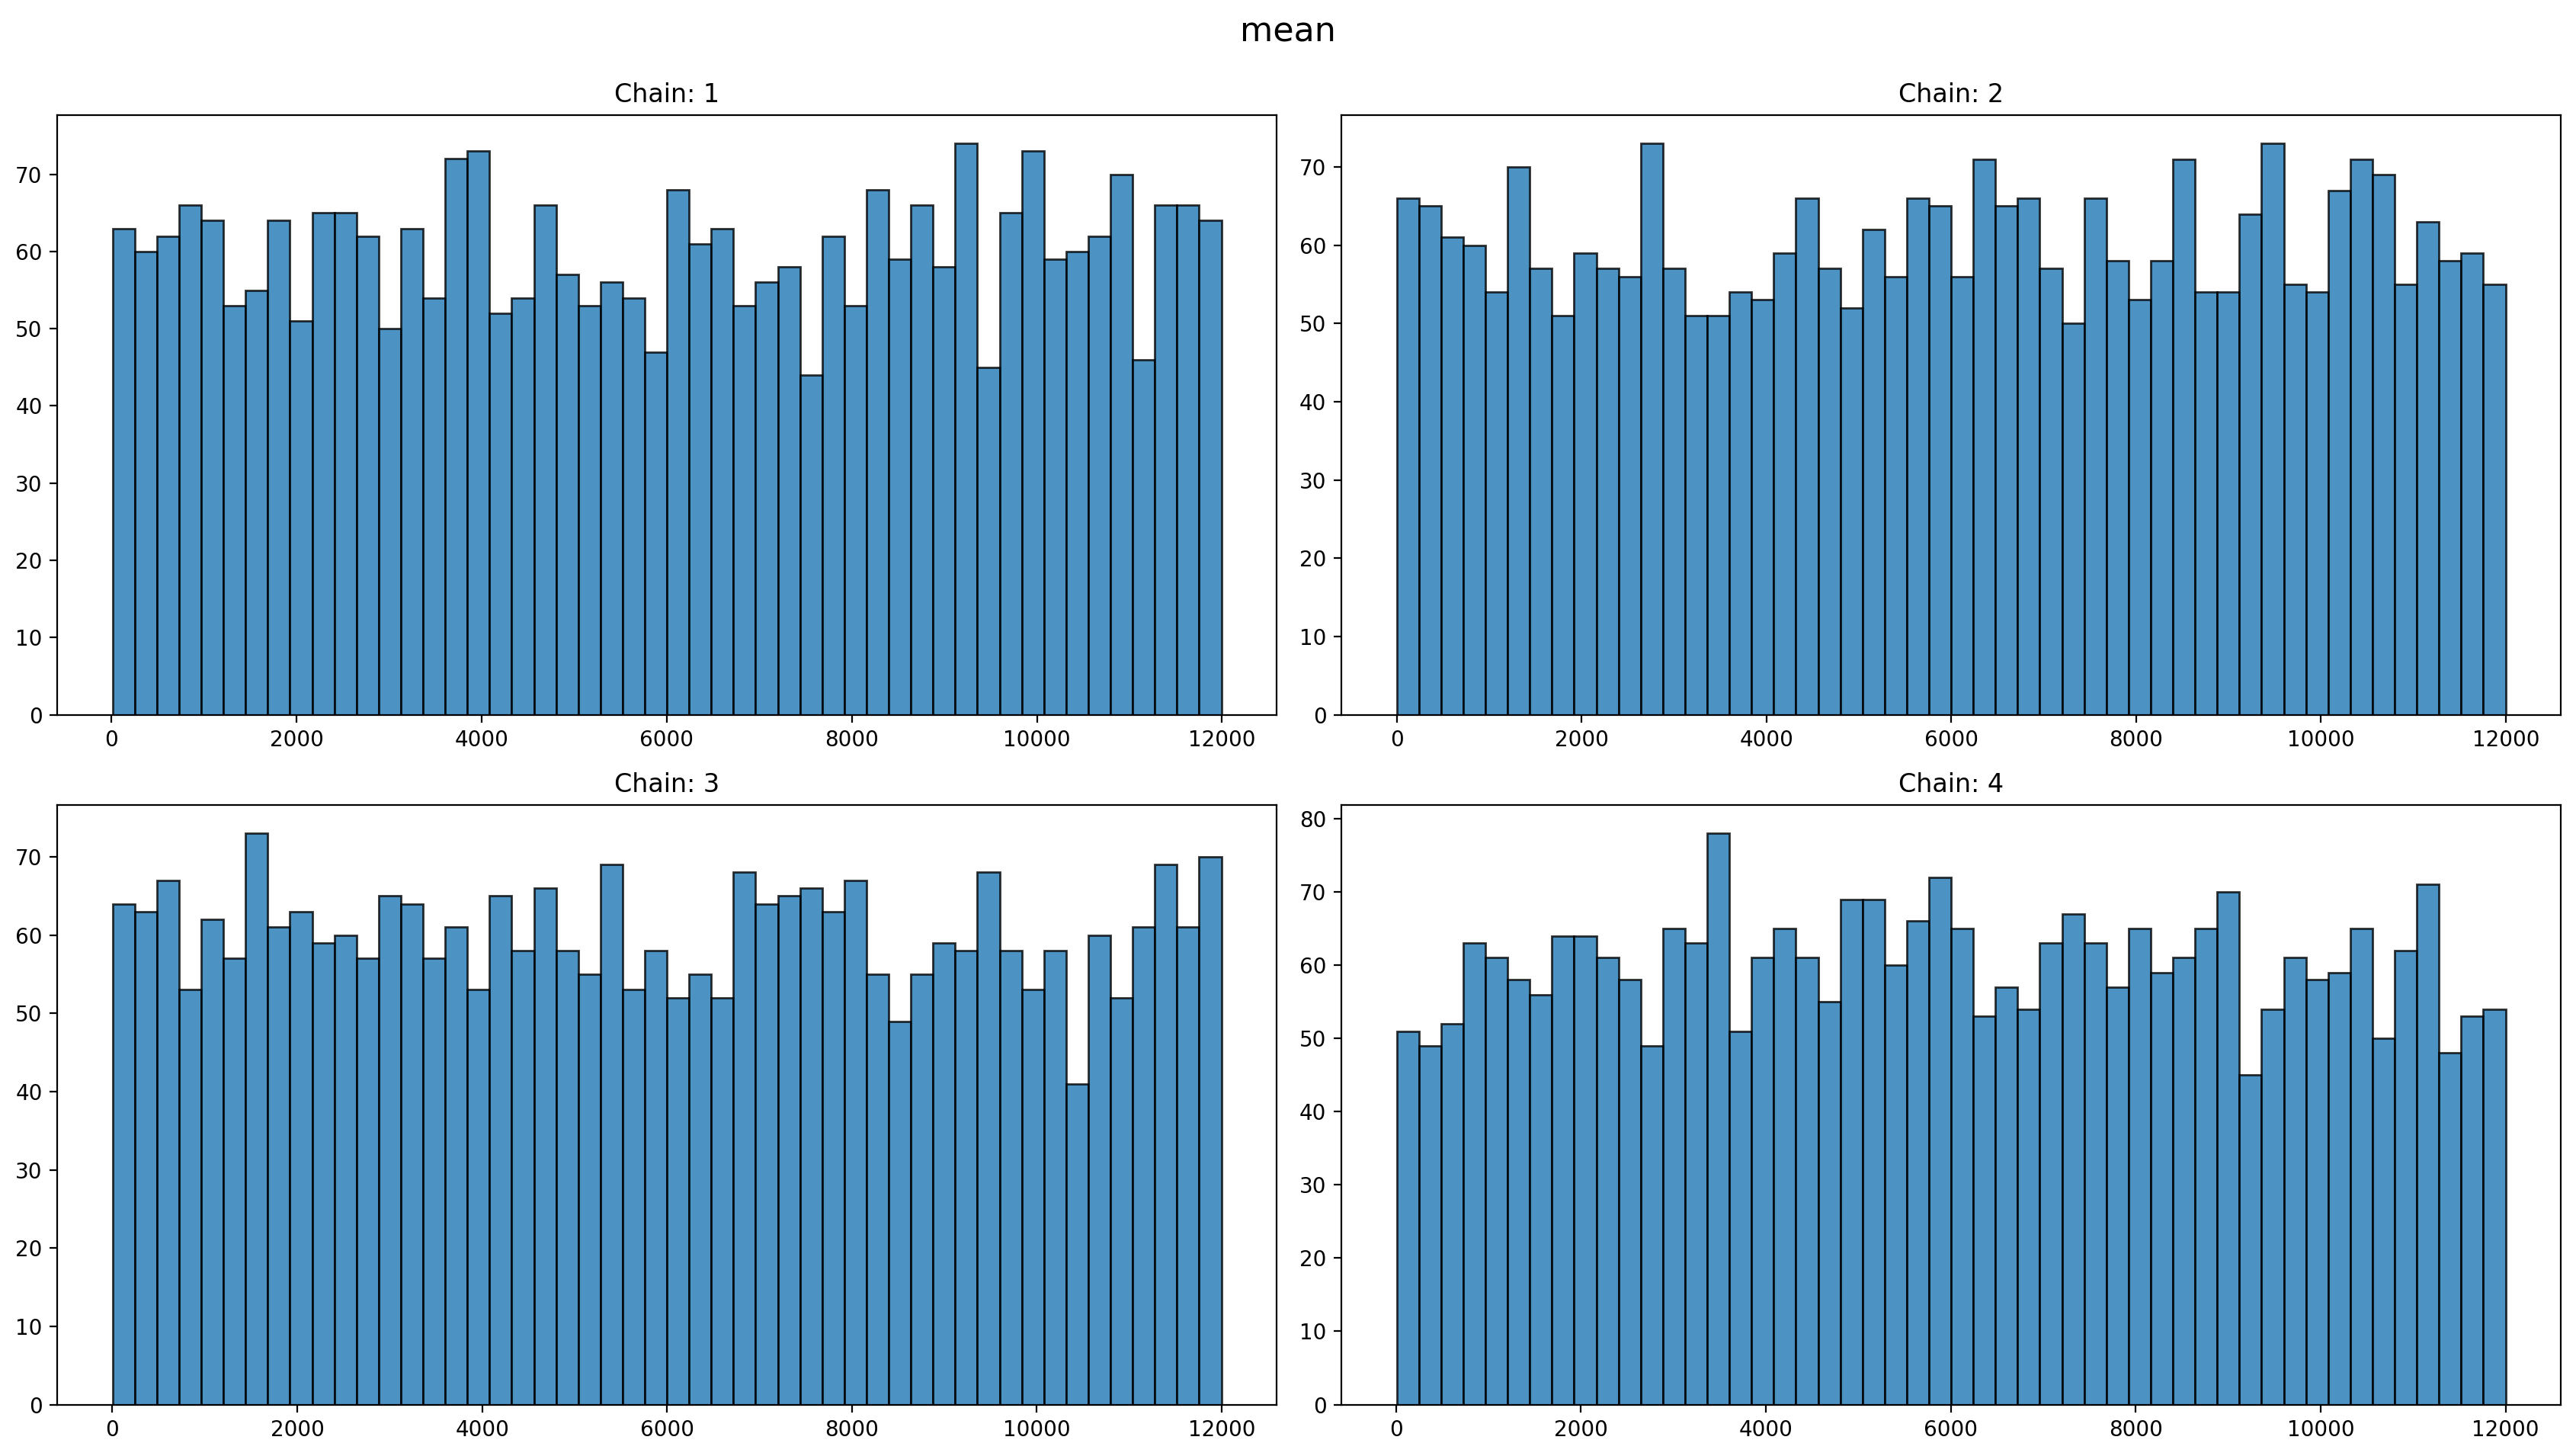

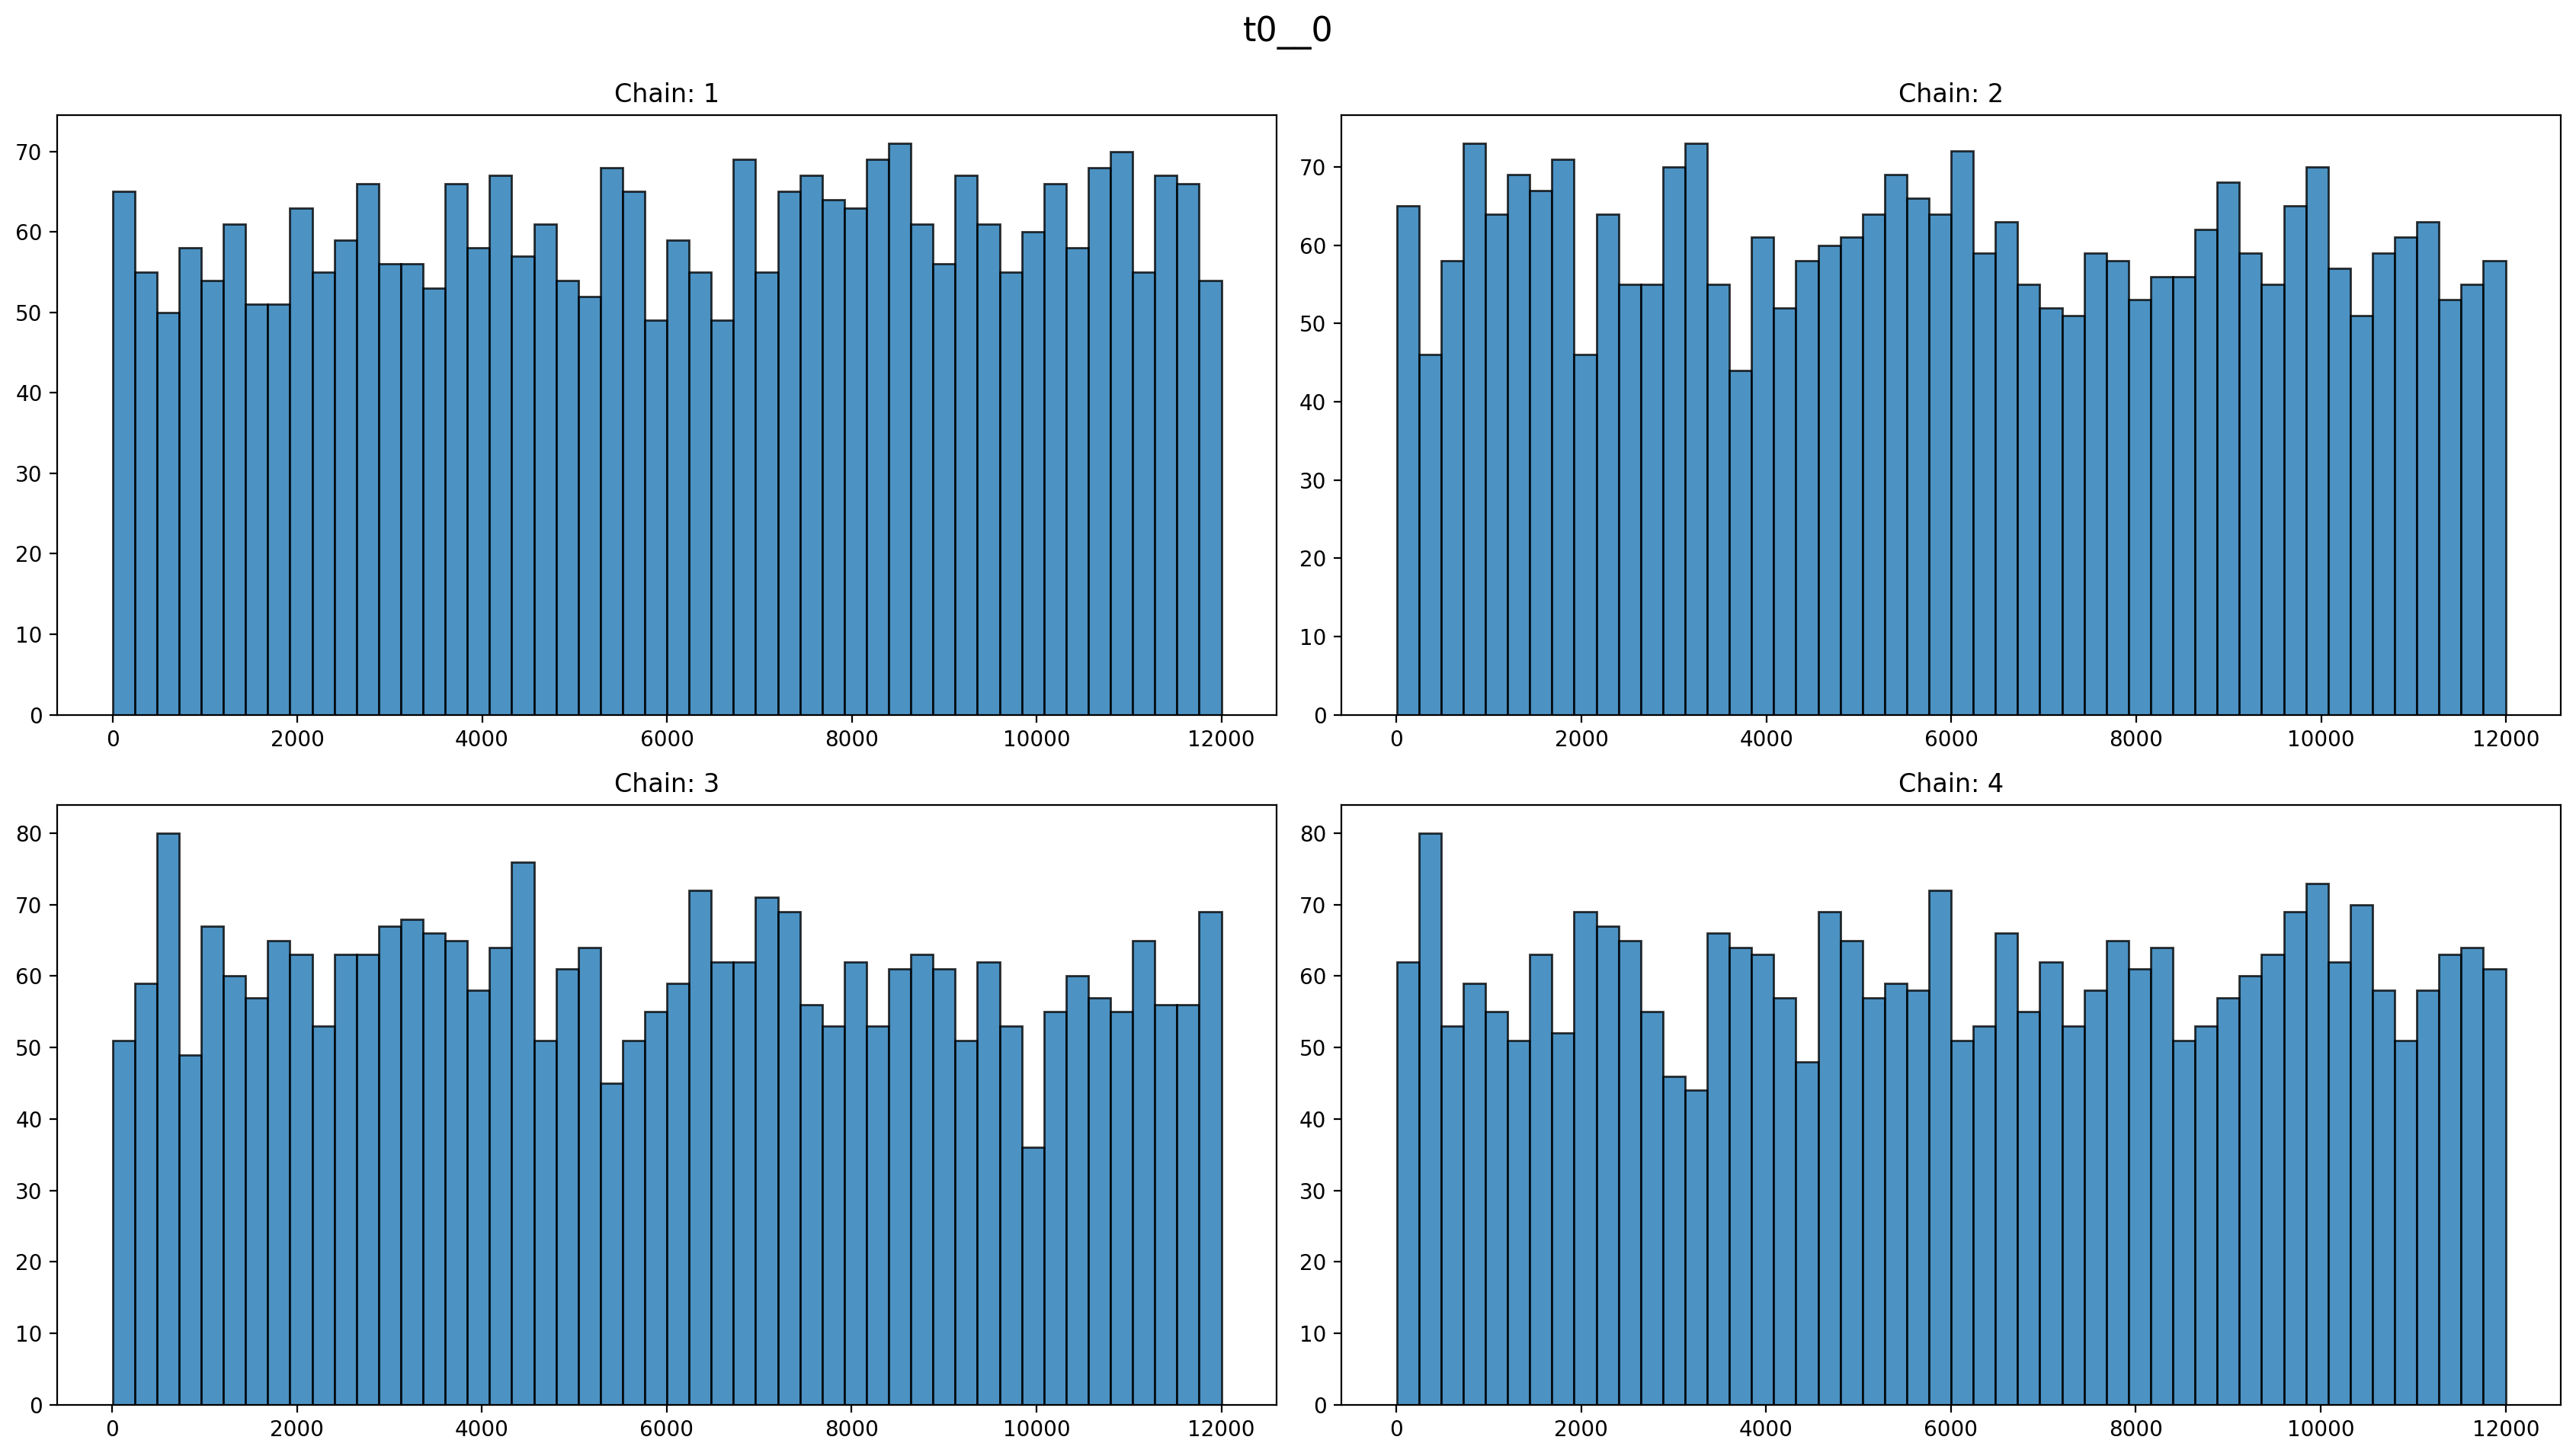

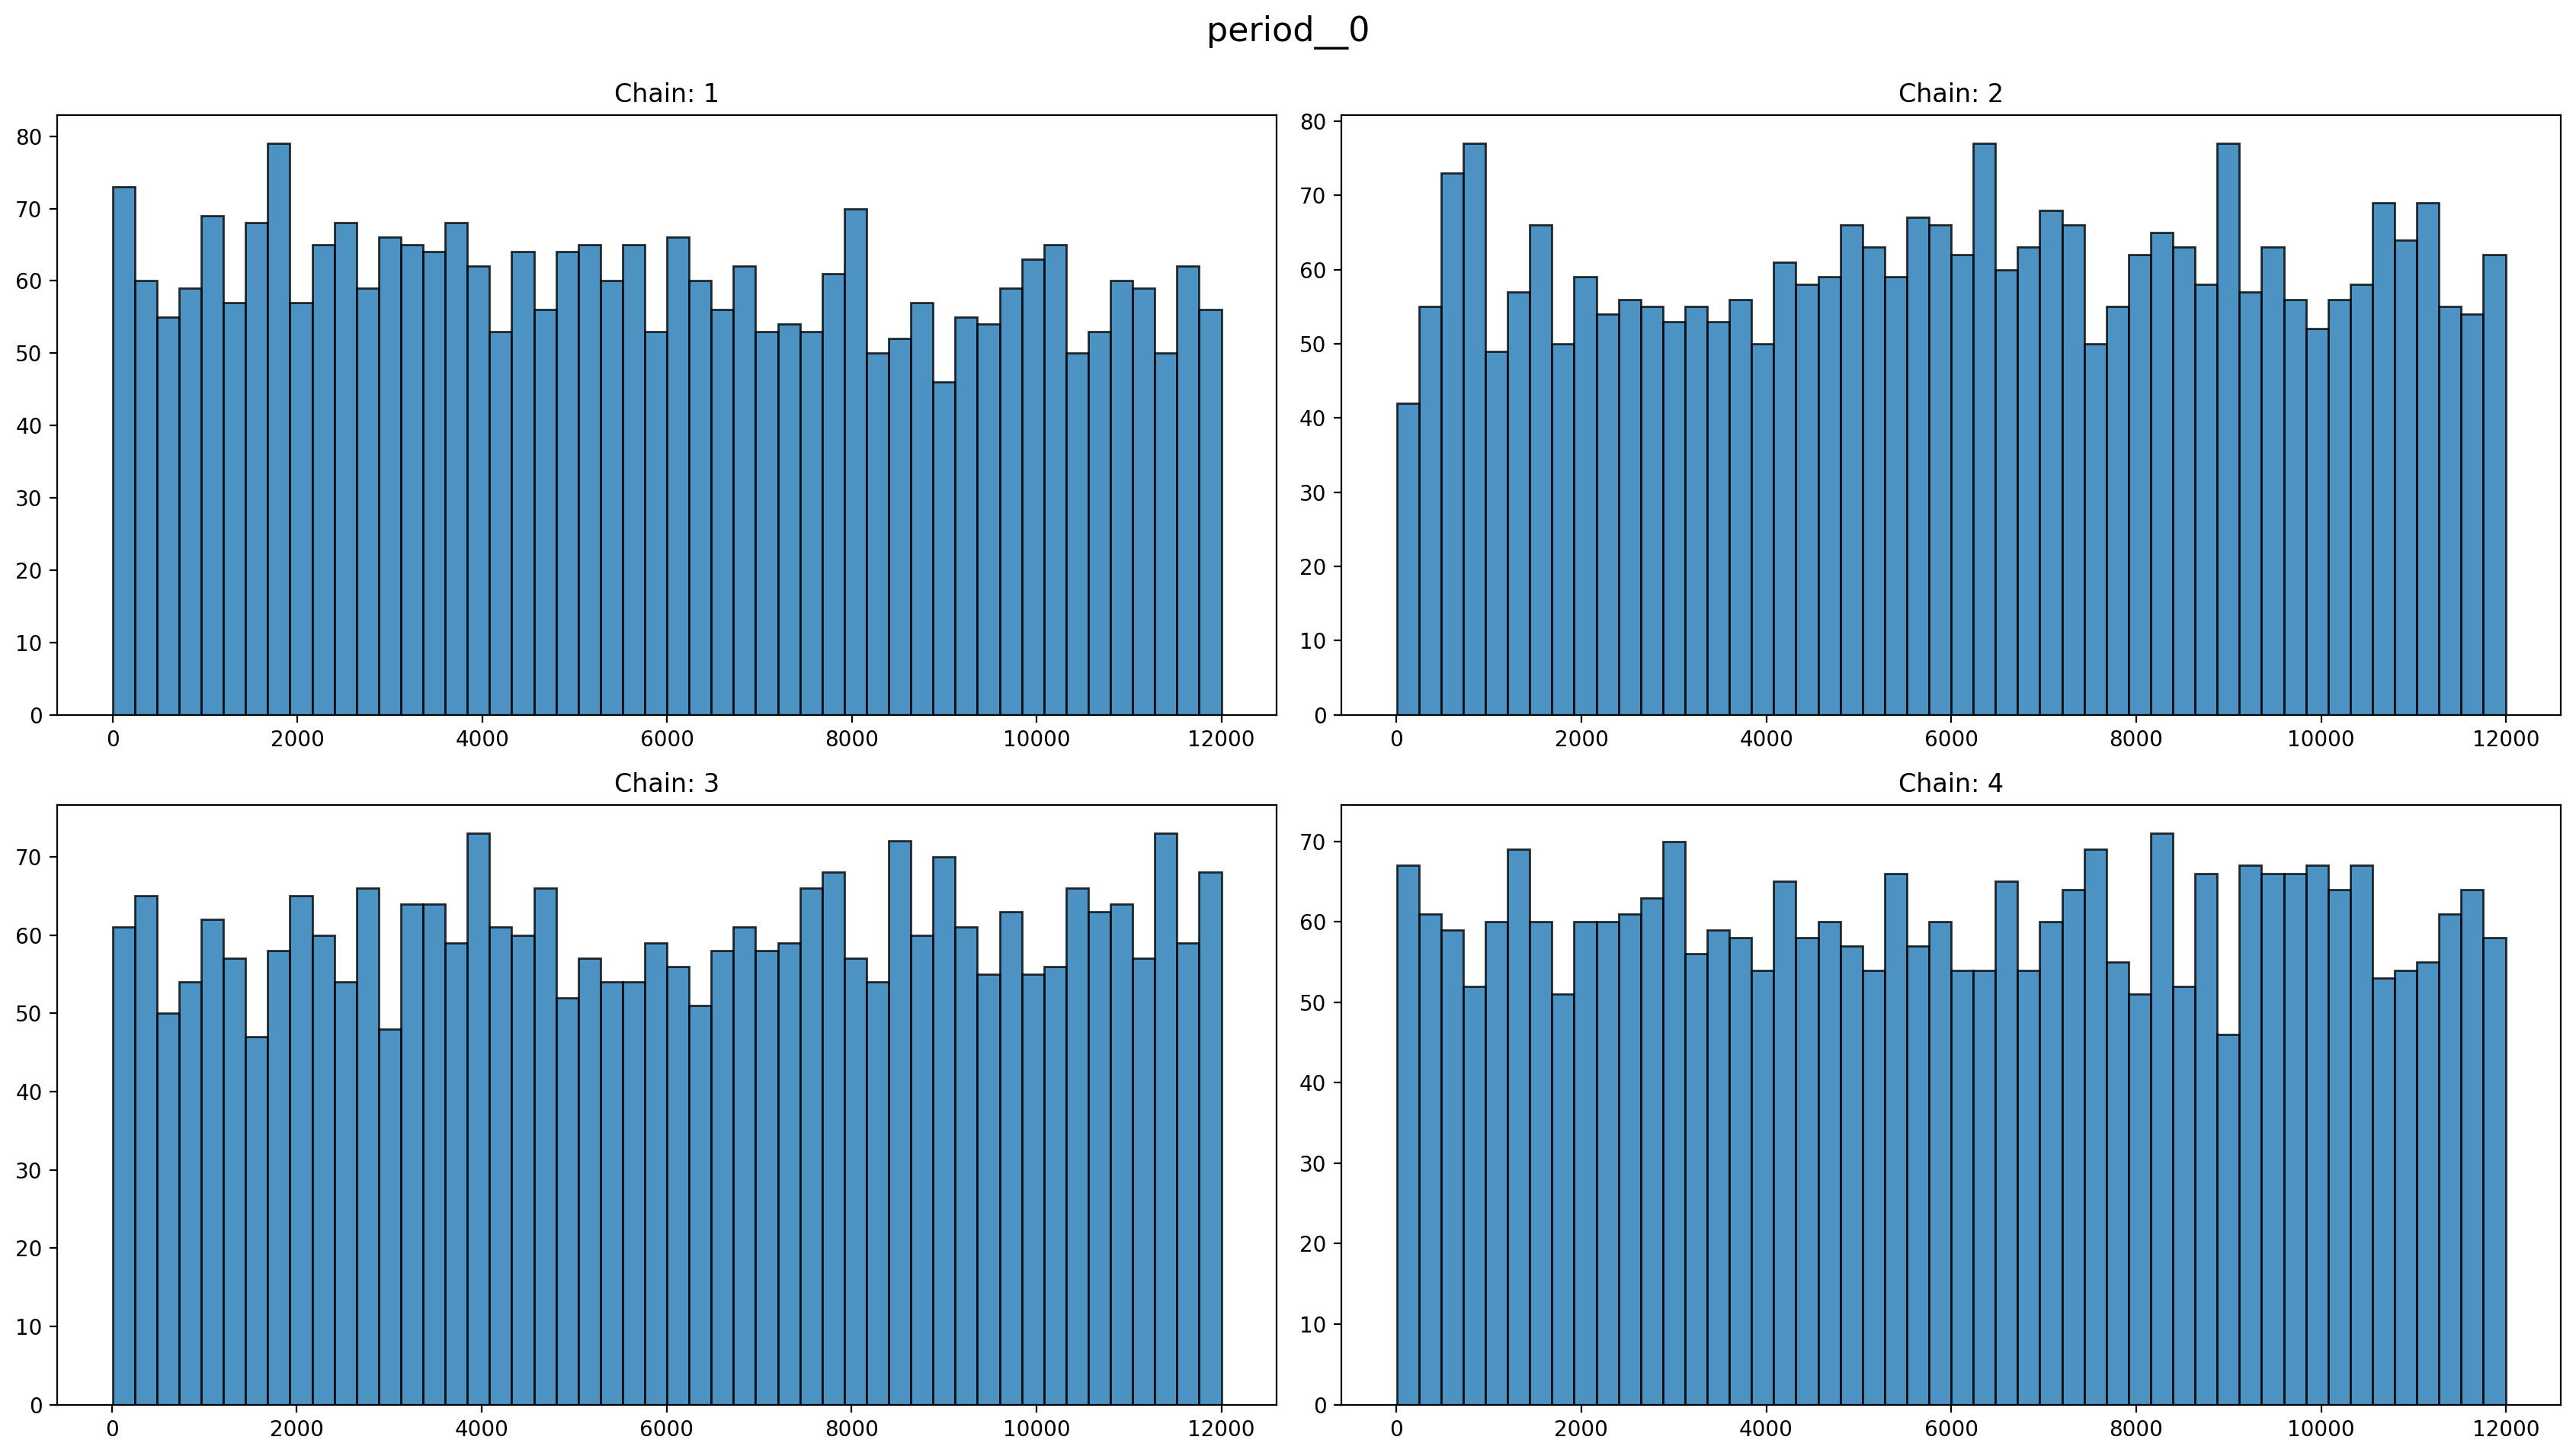

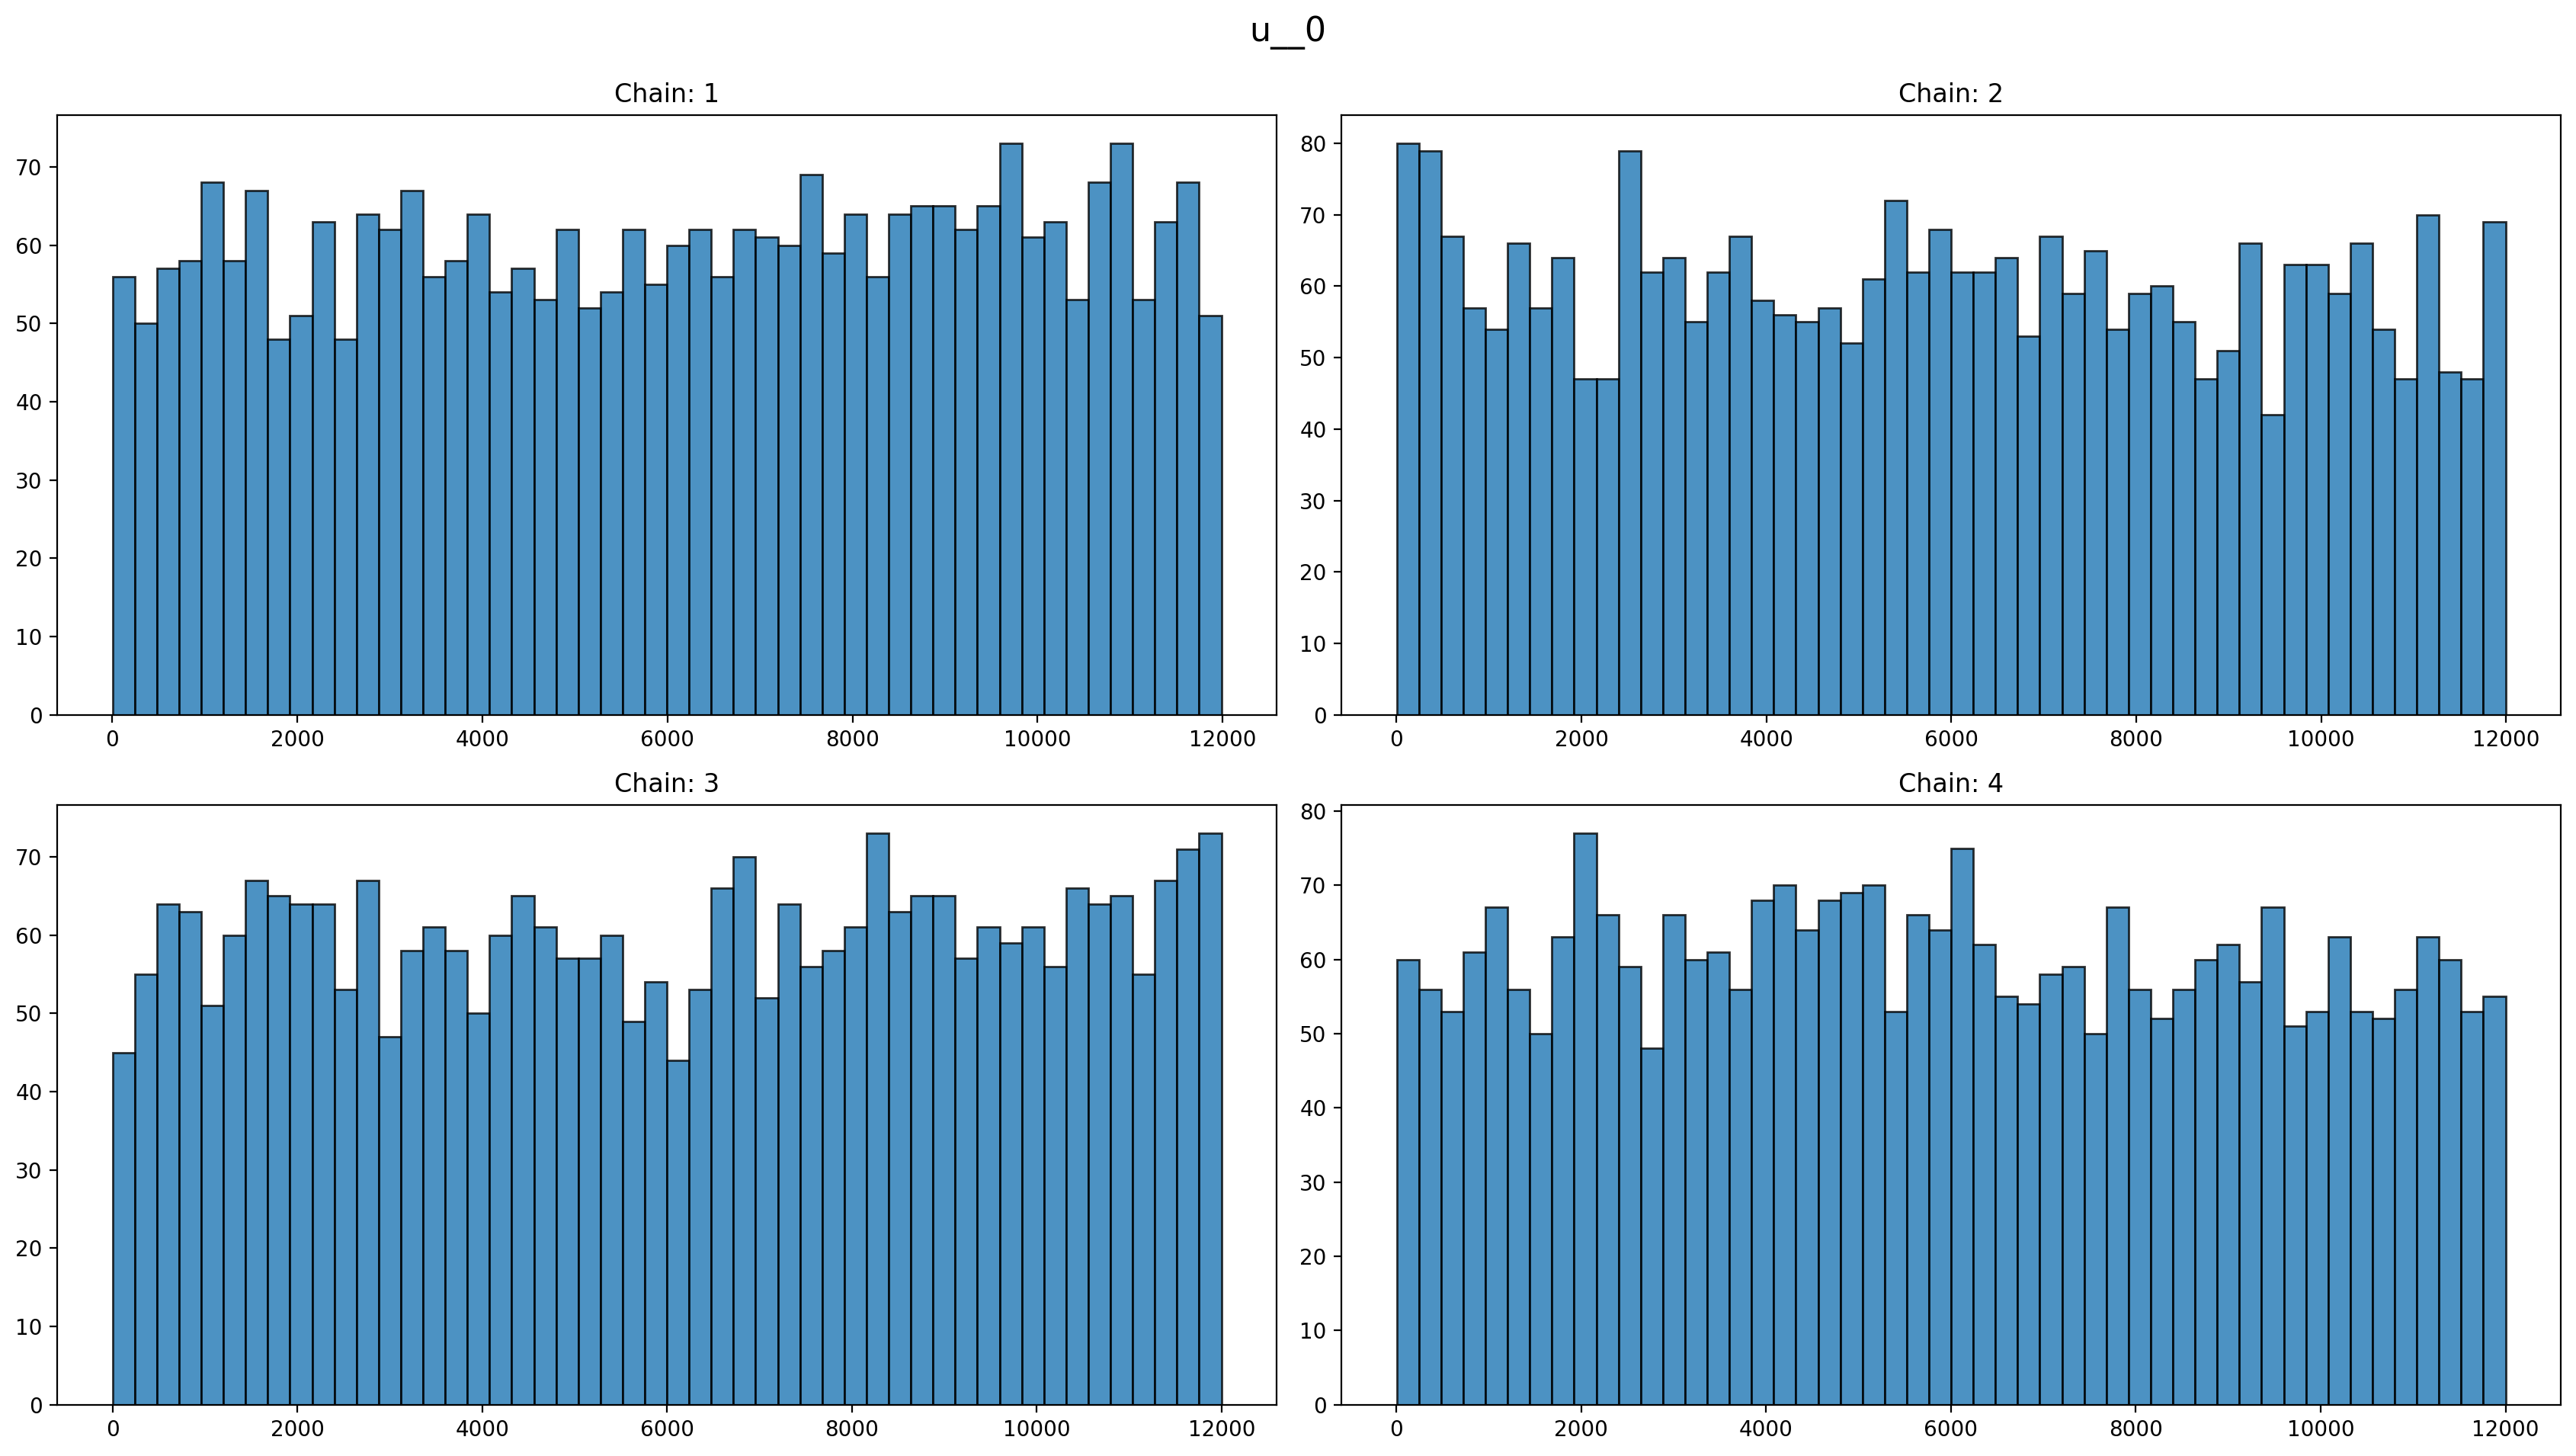

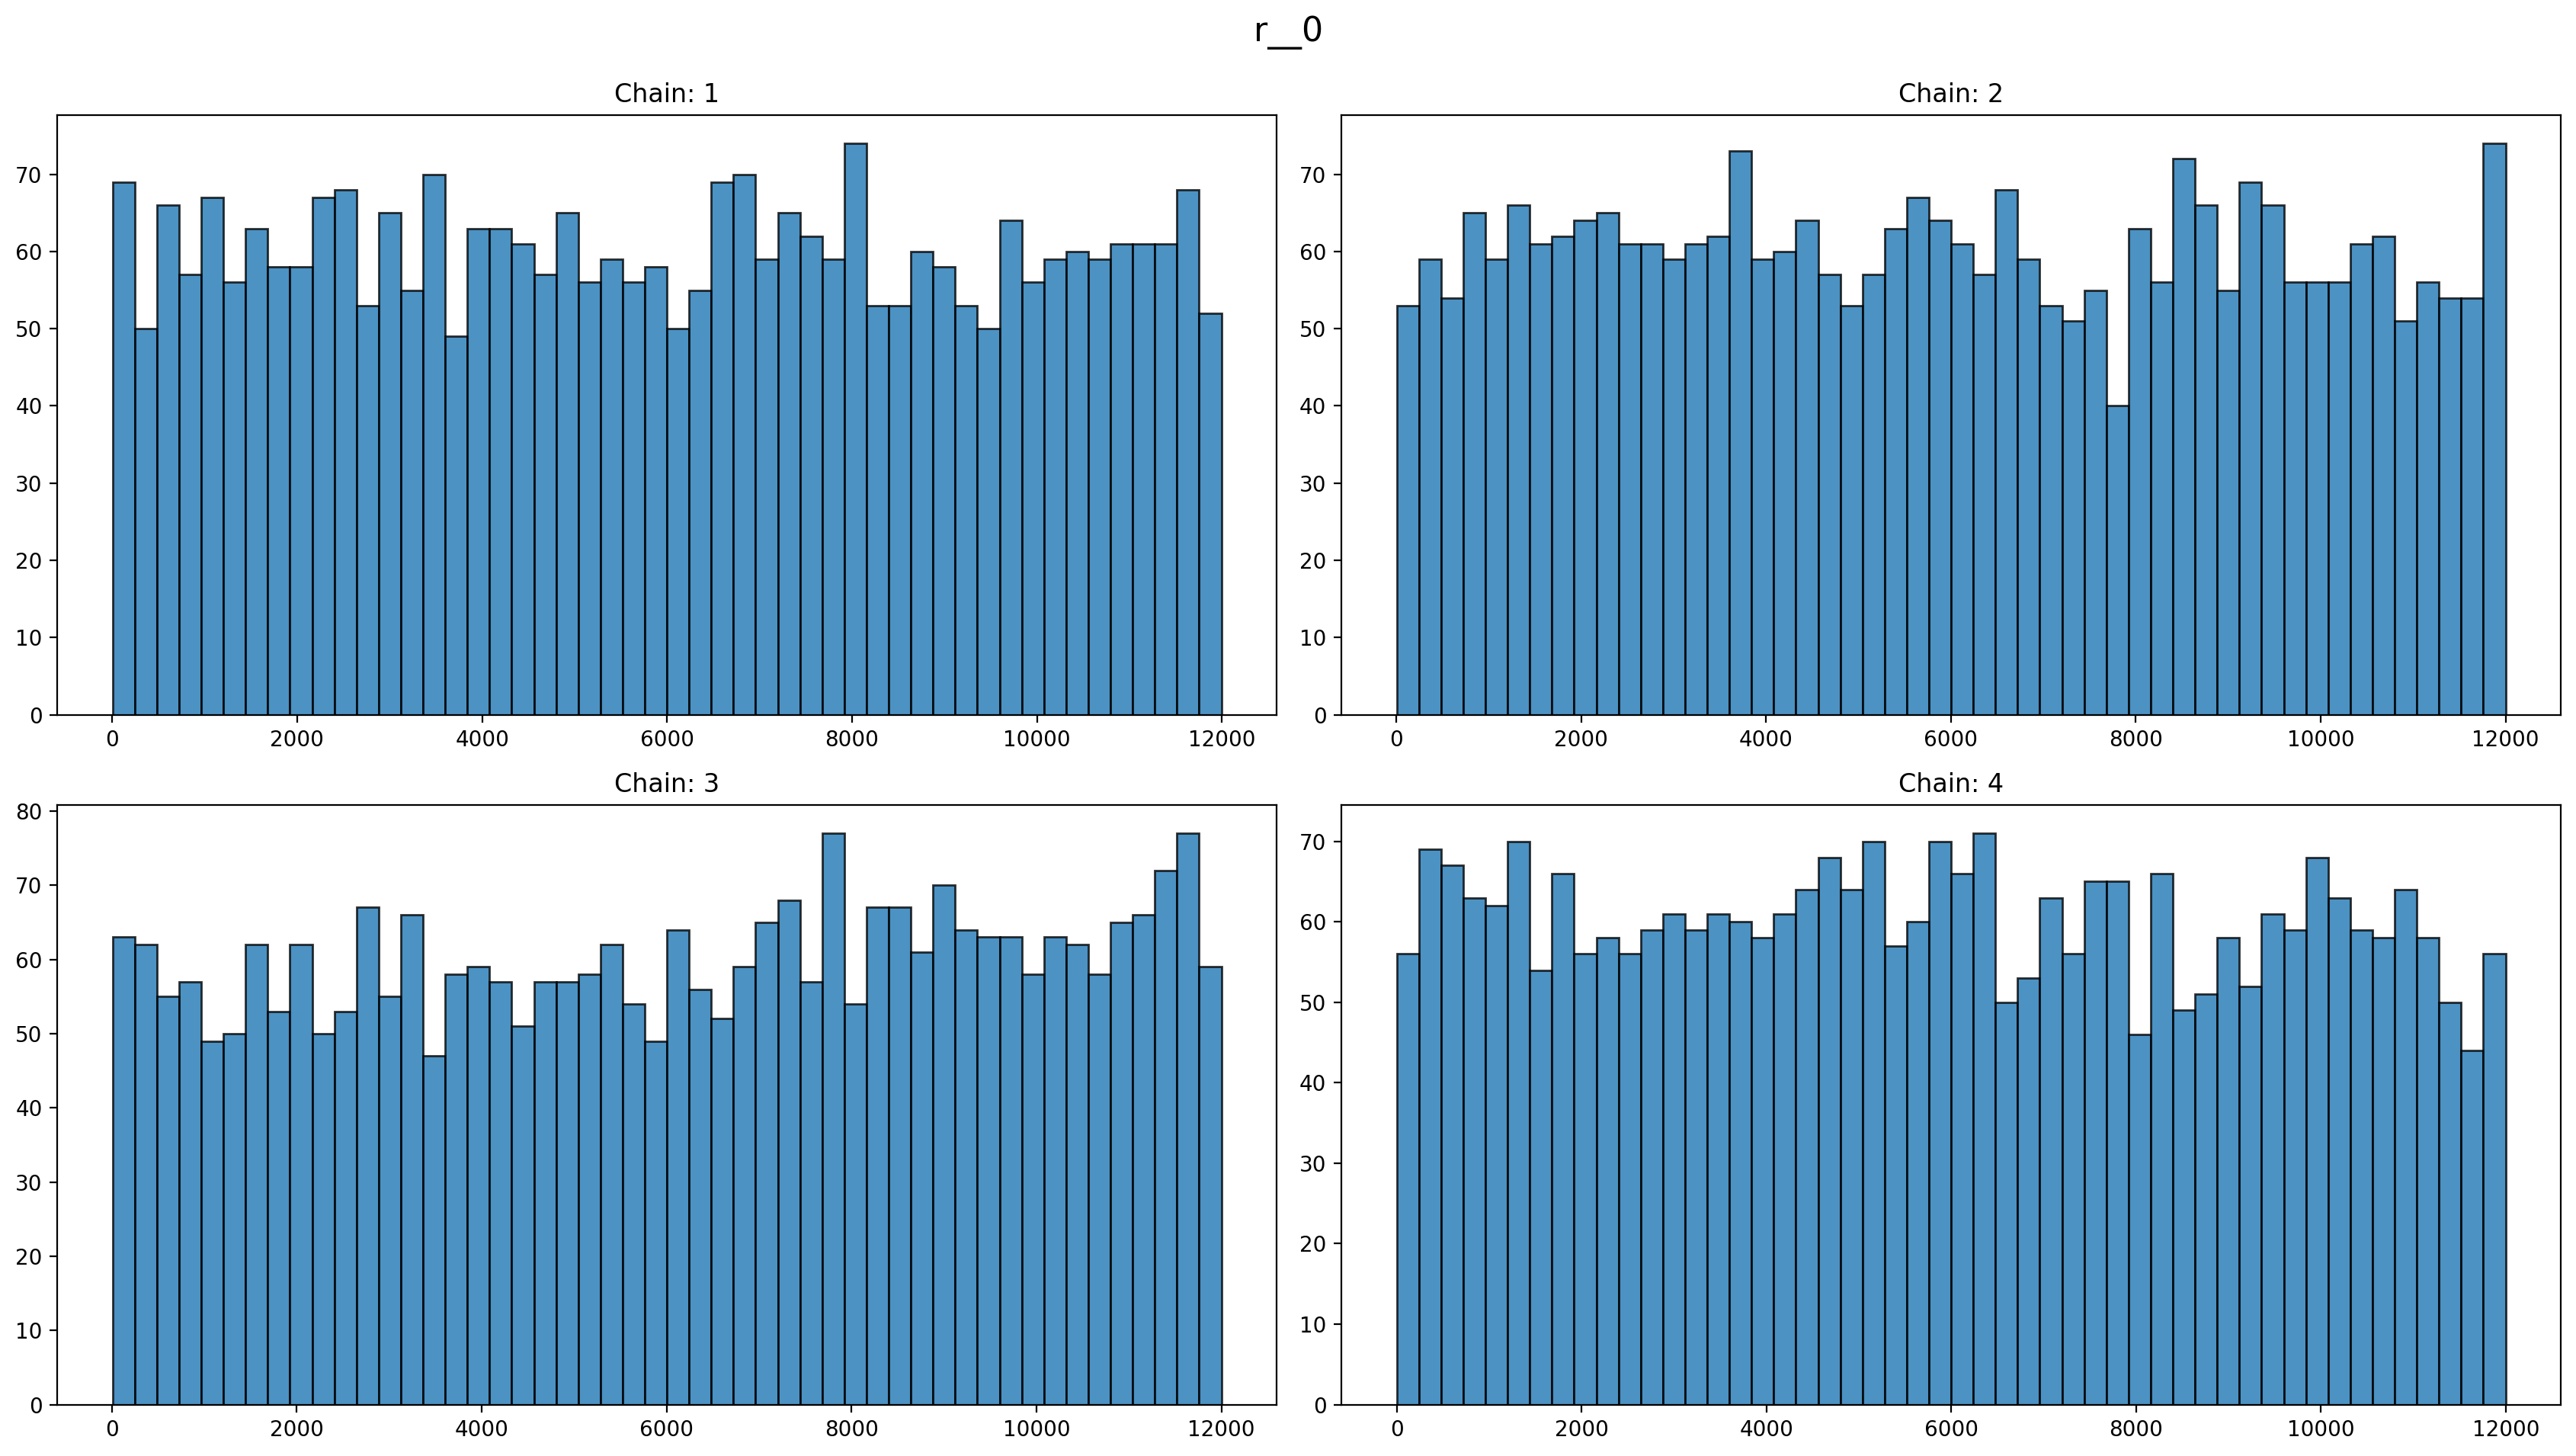

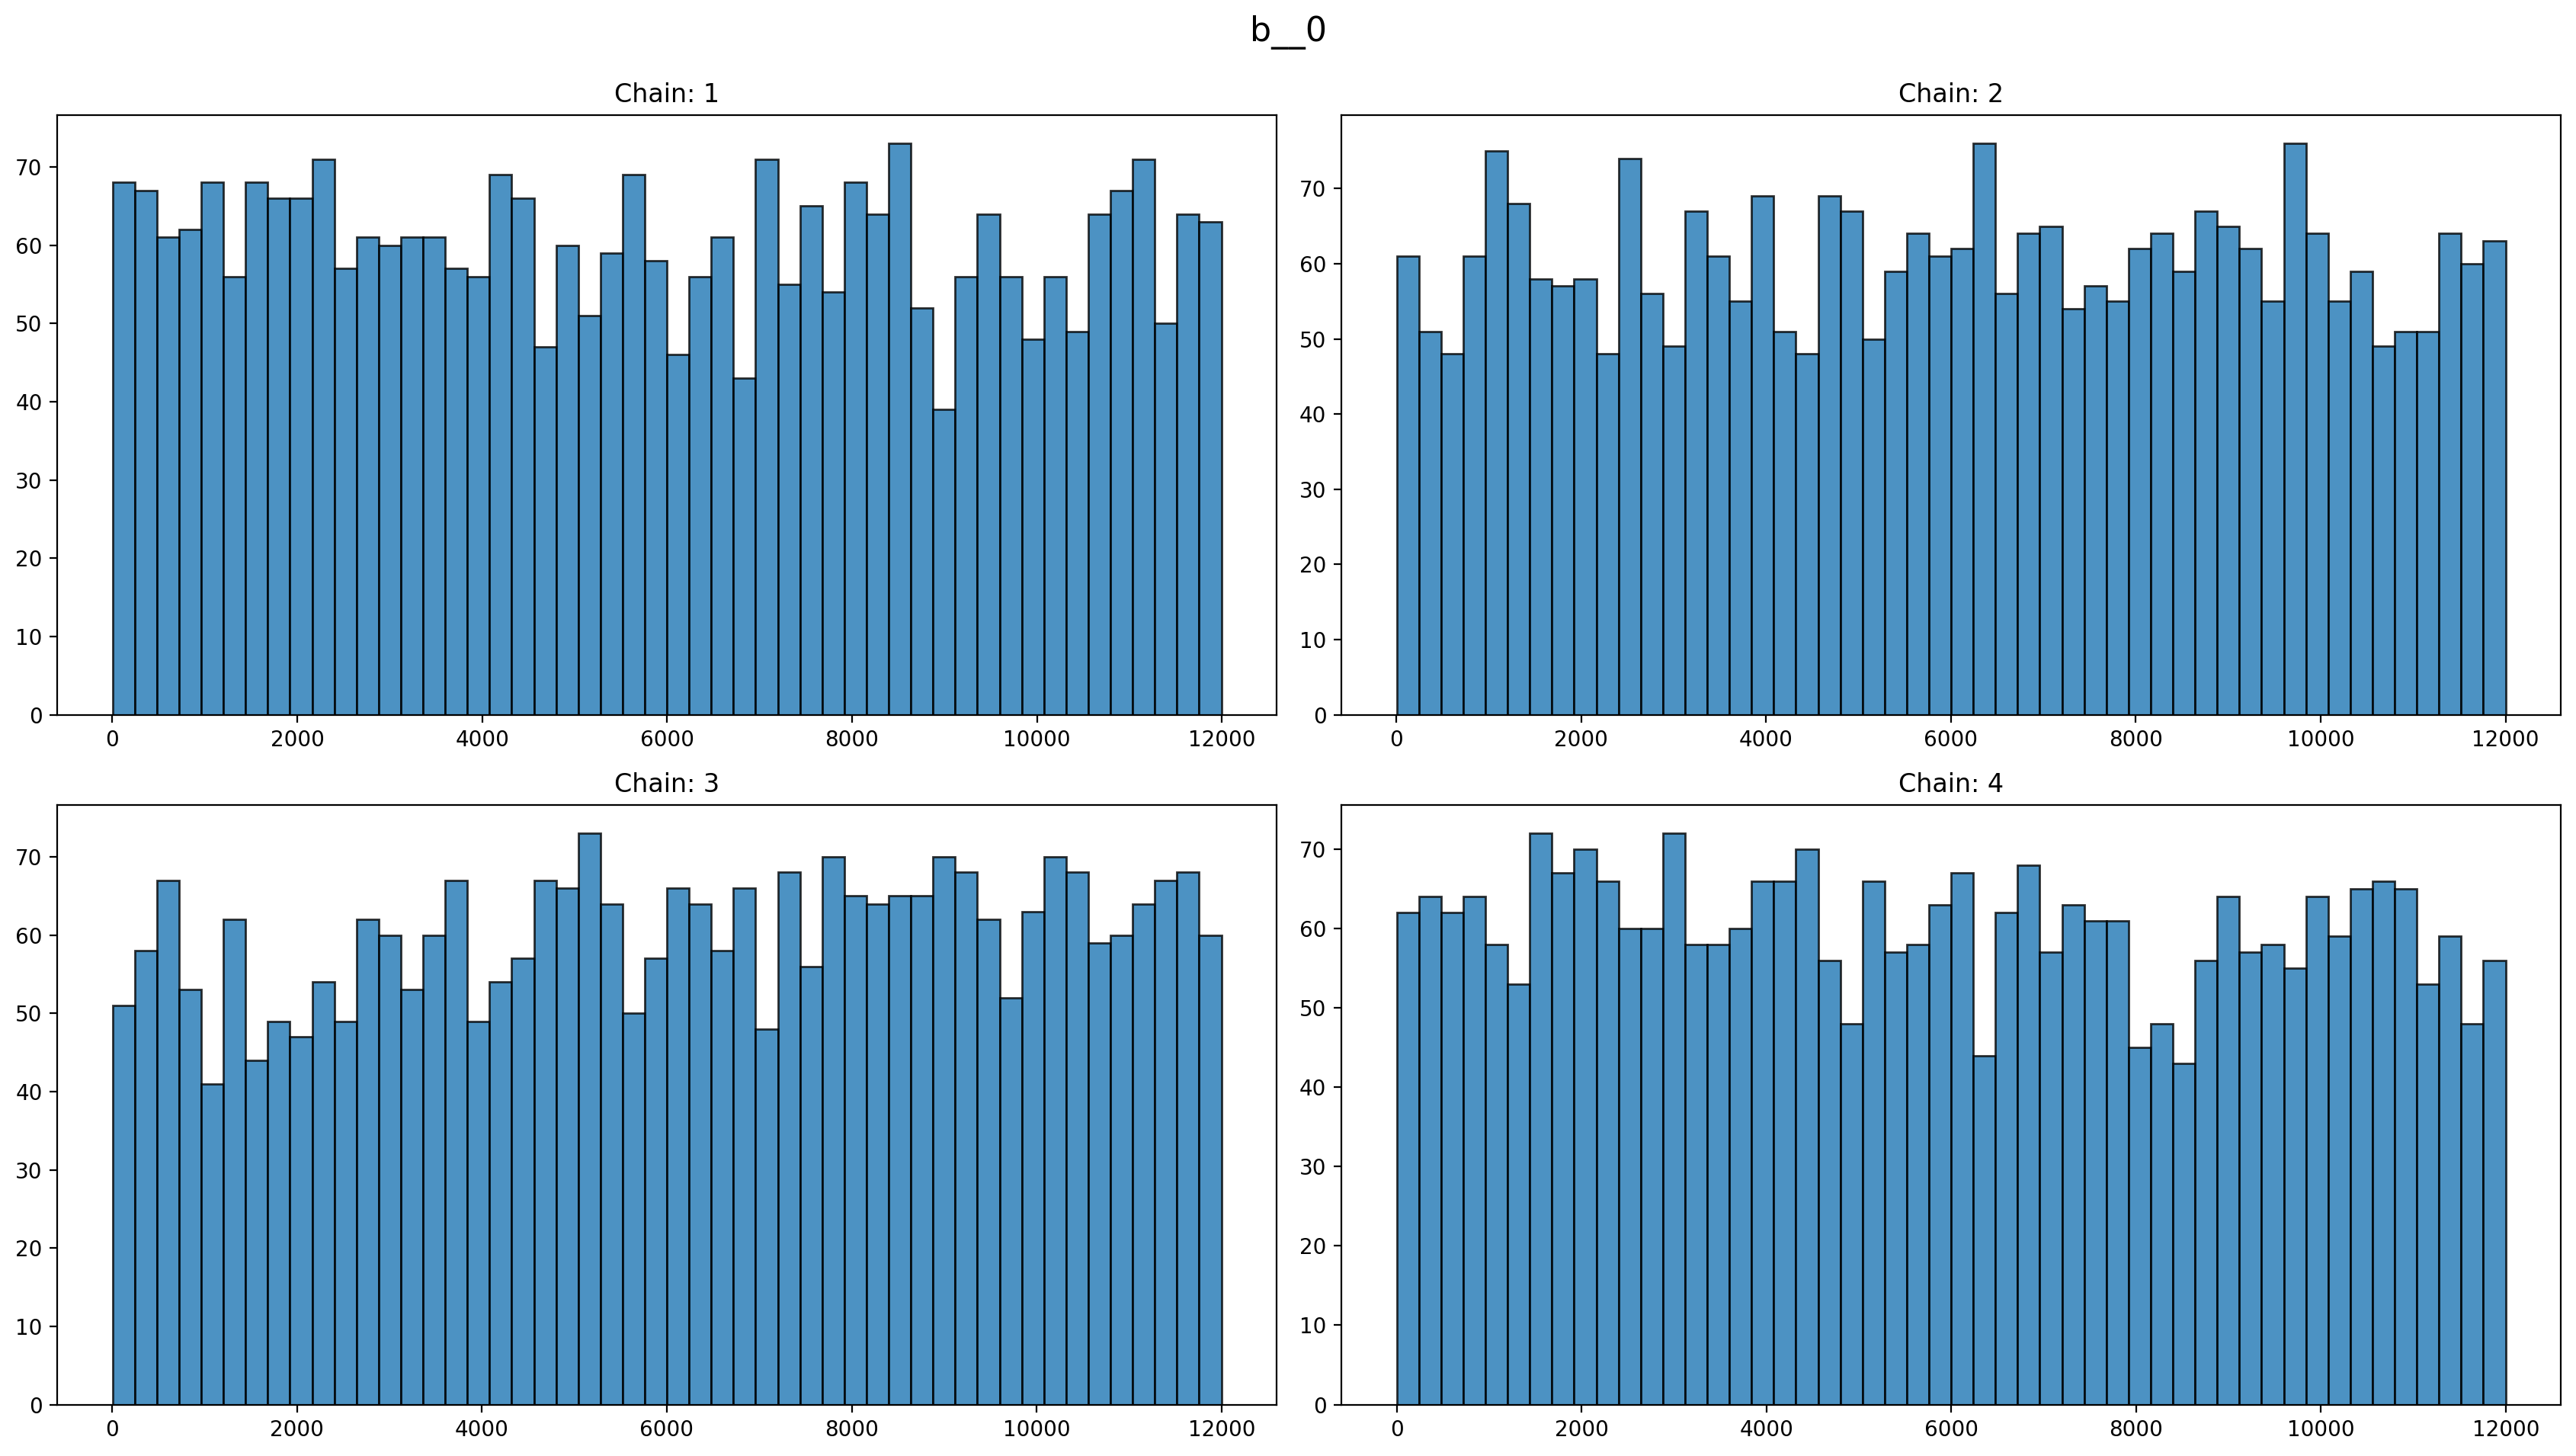


planet 2


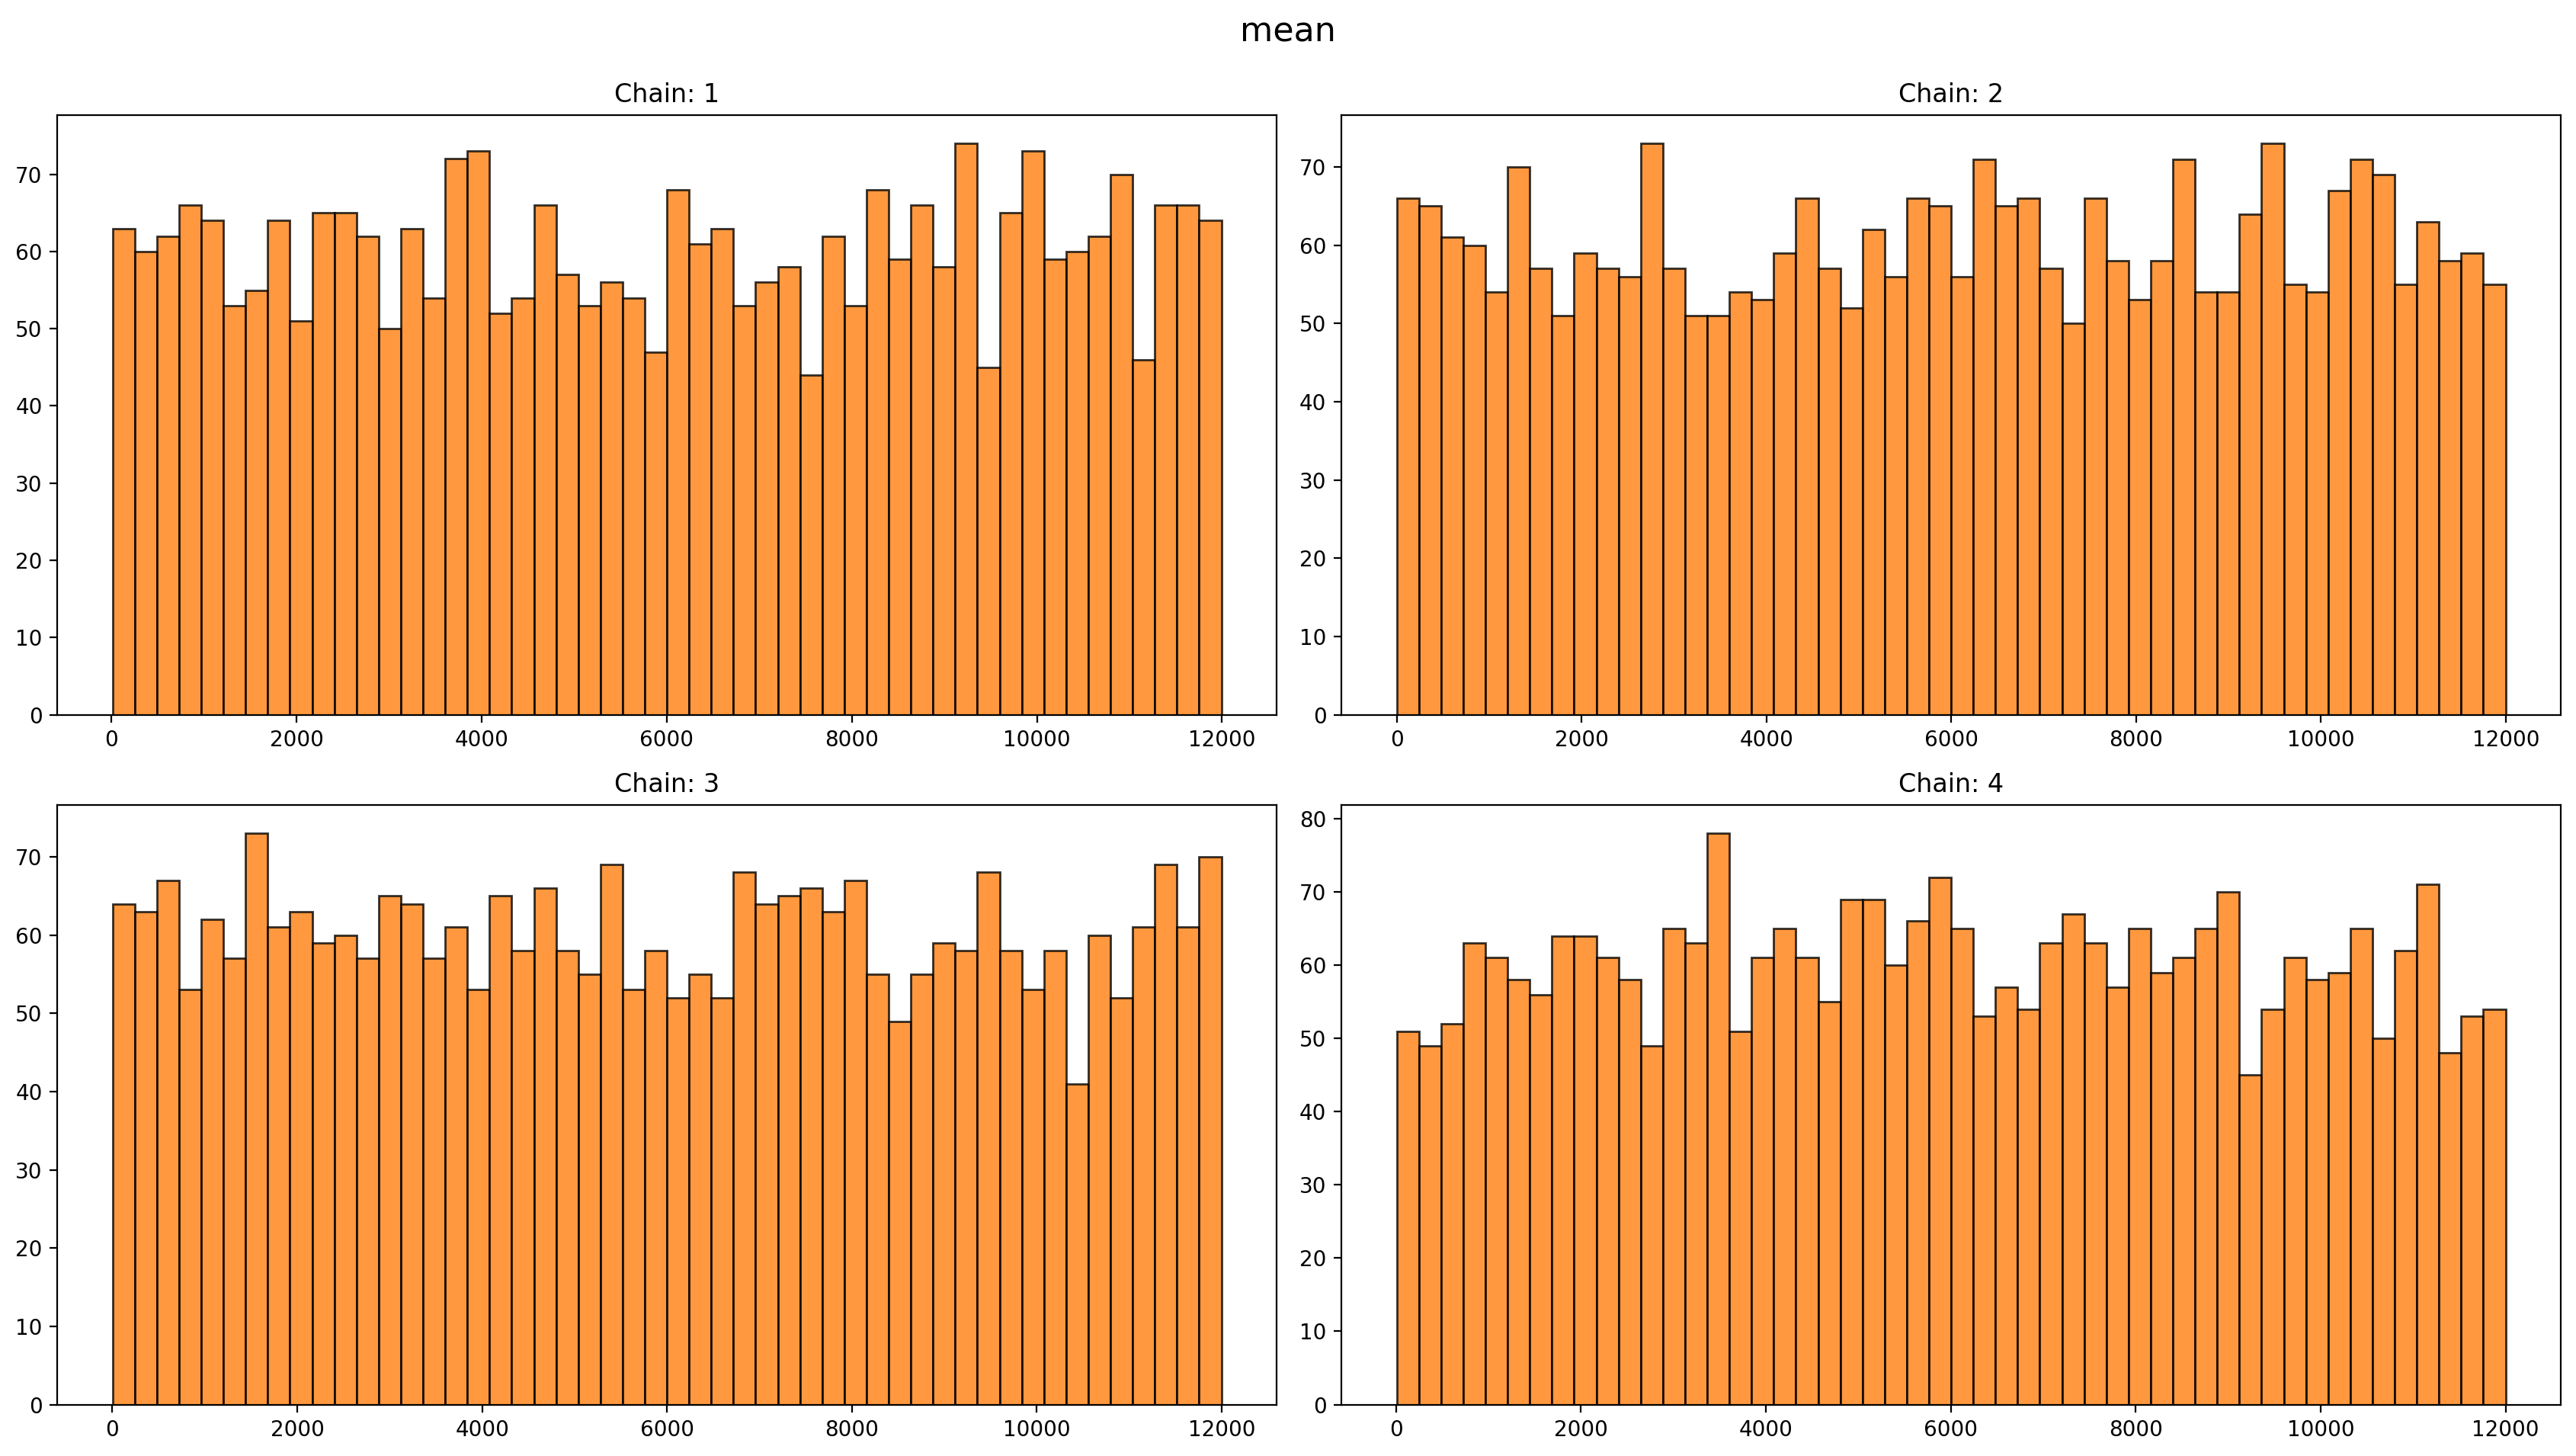

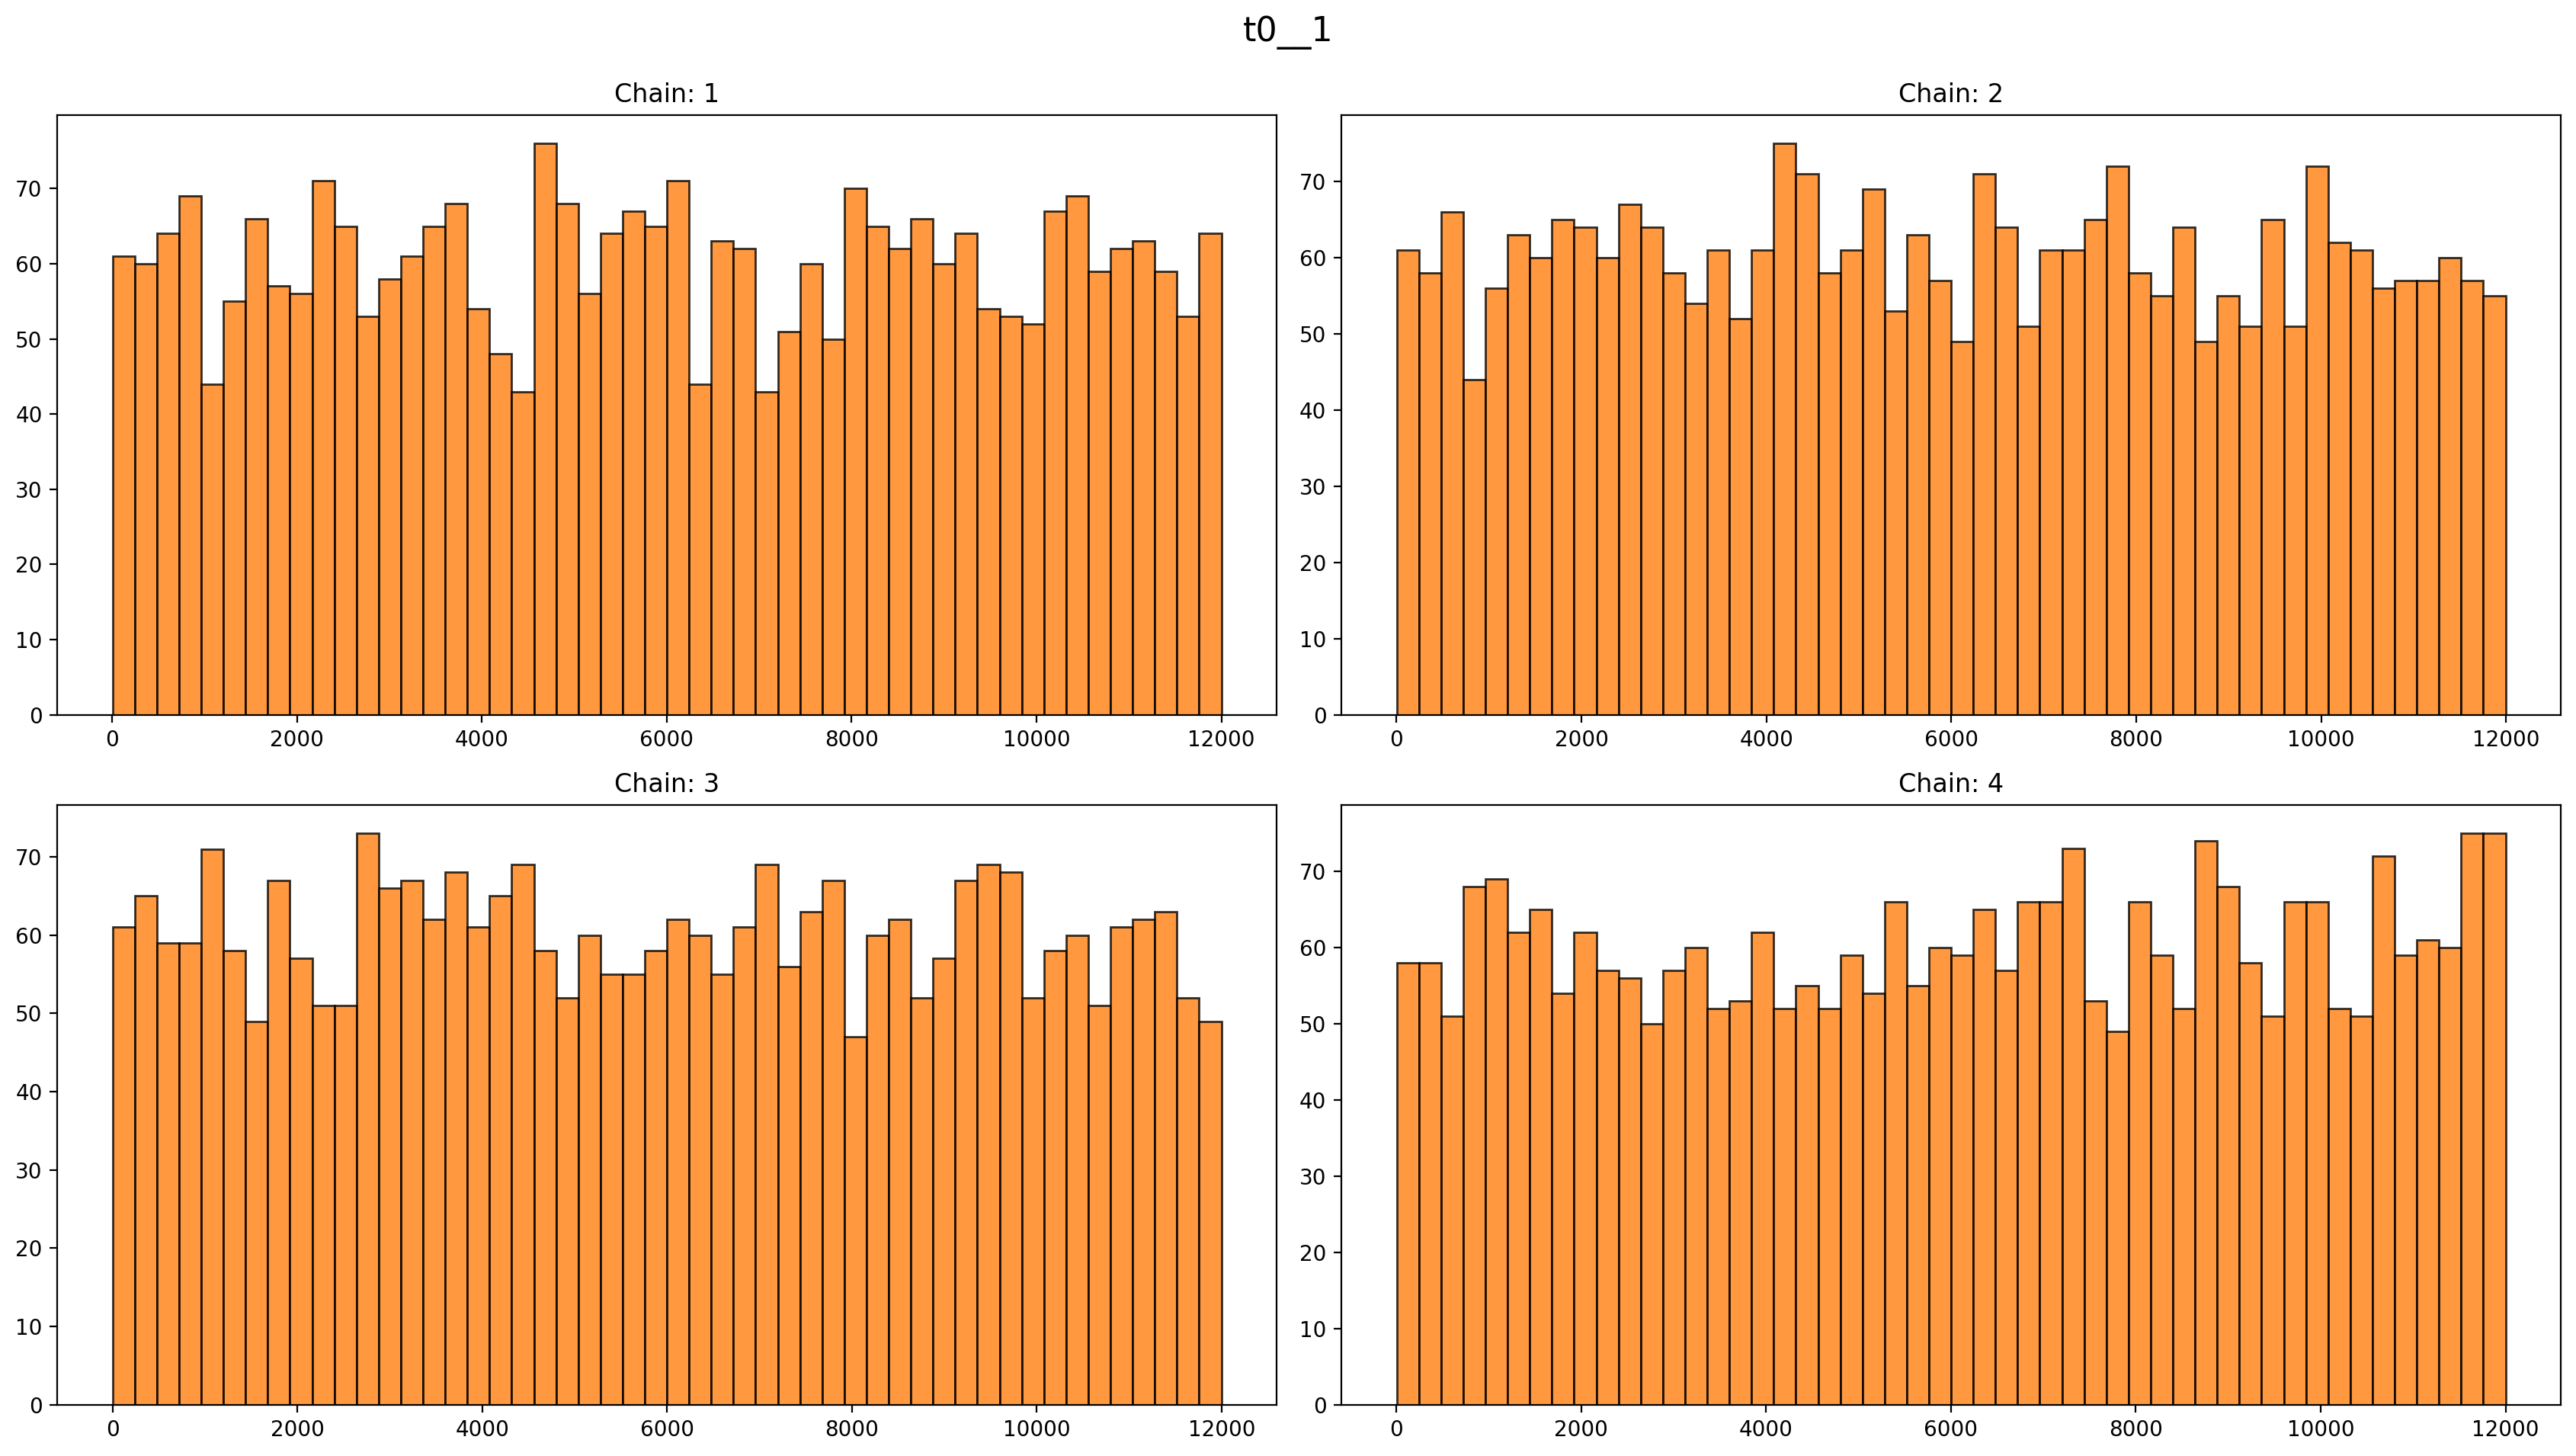

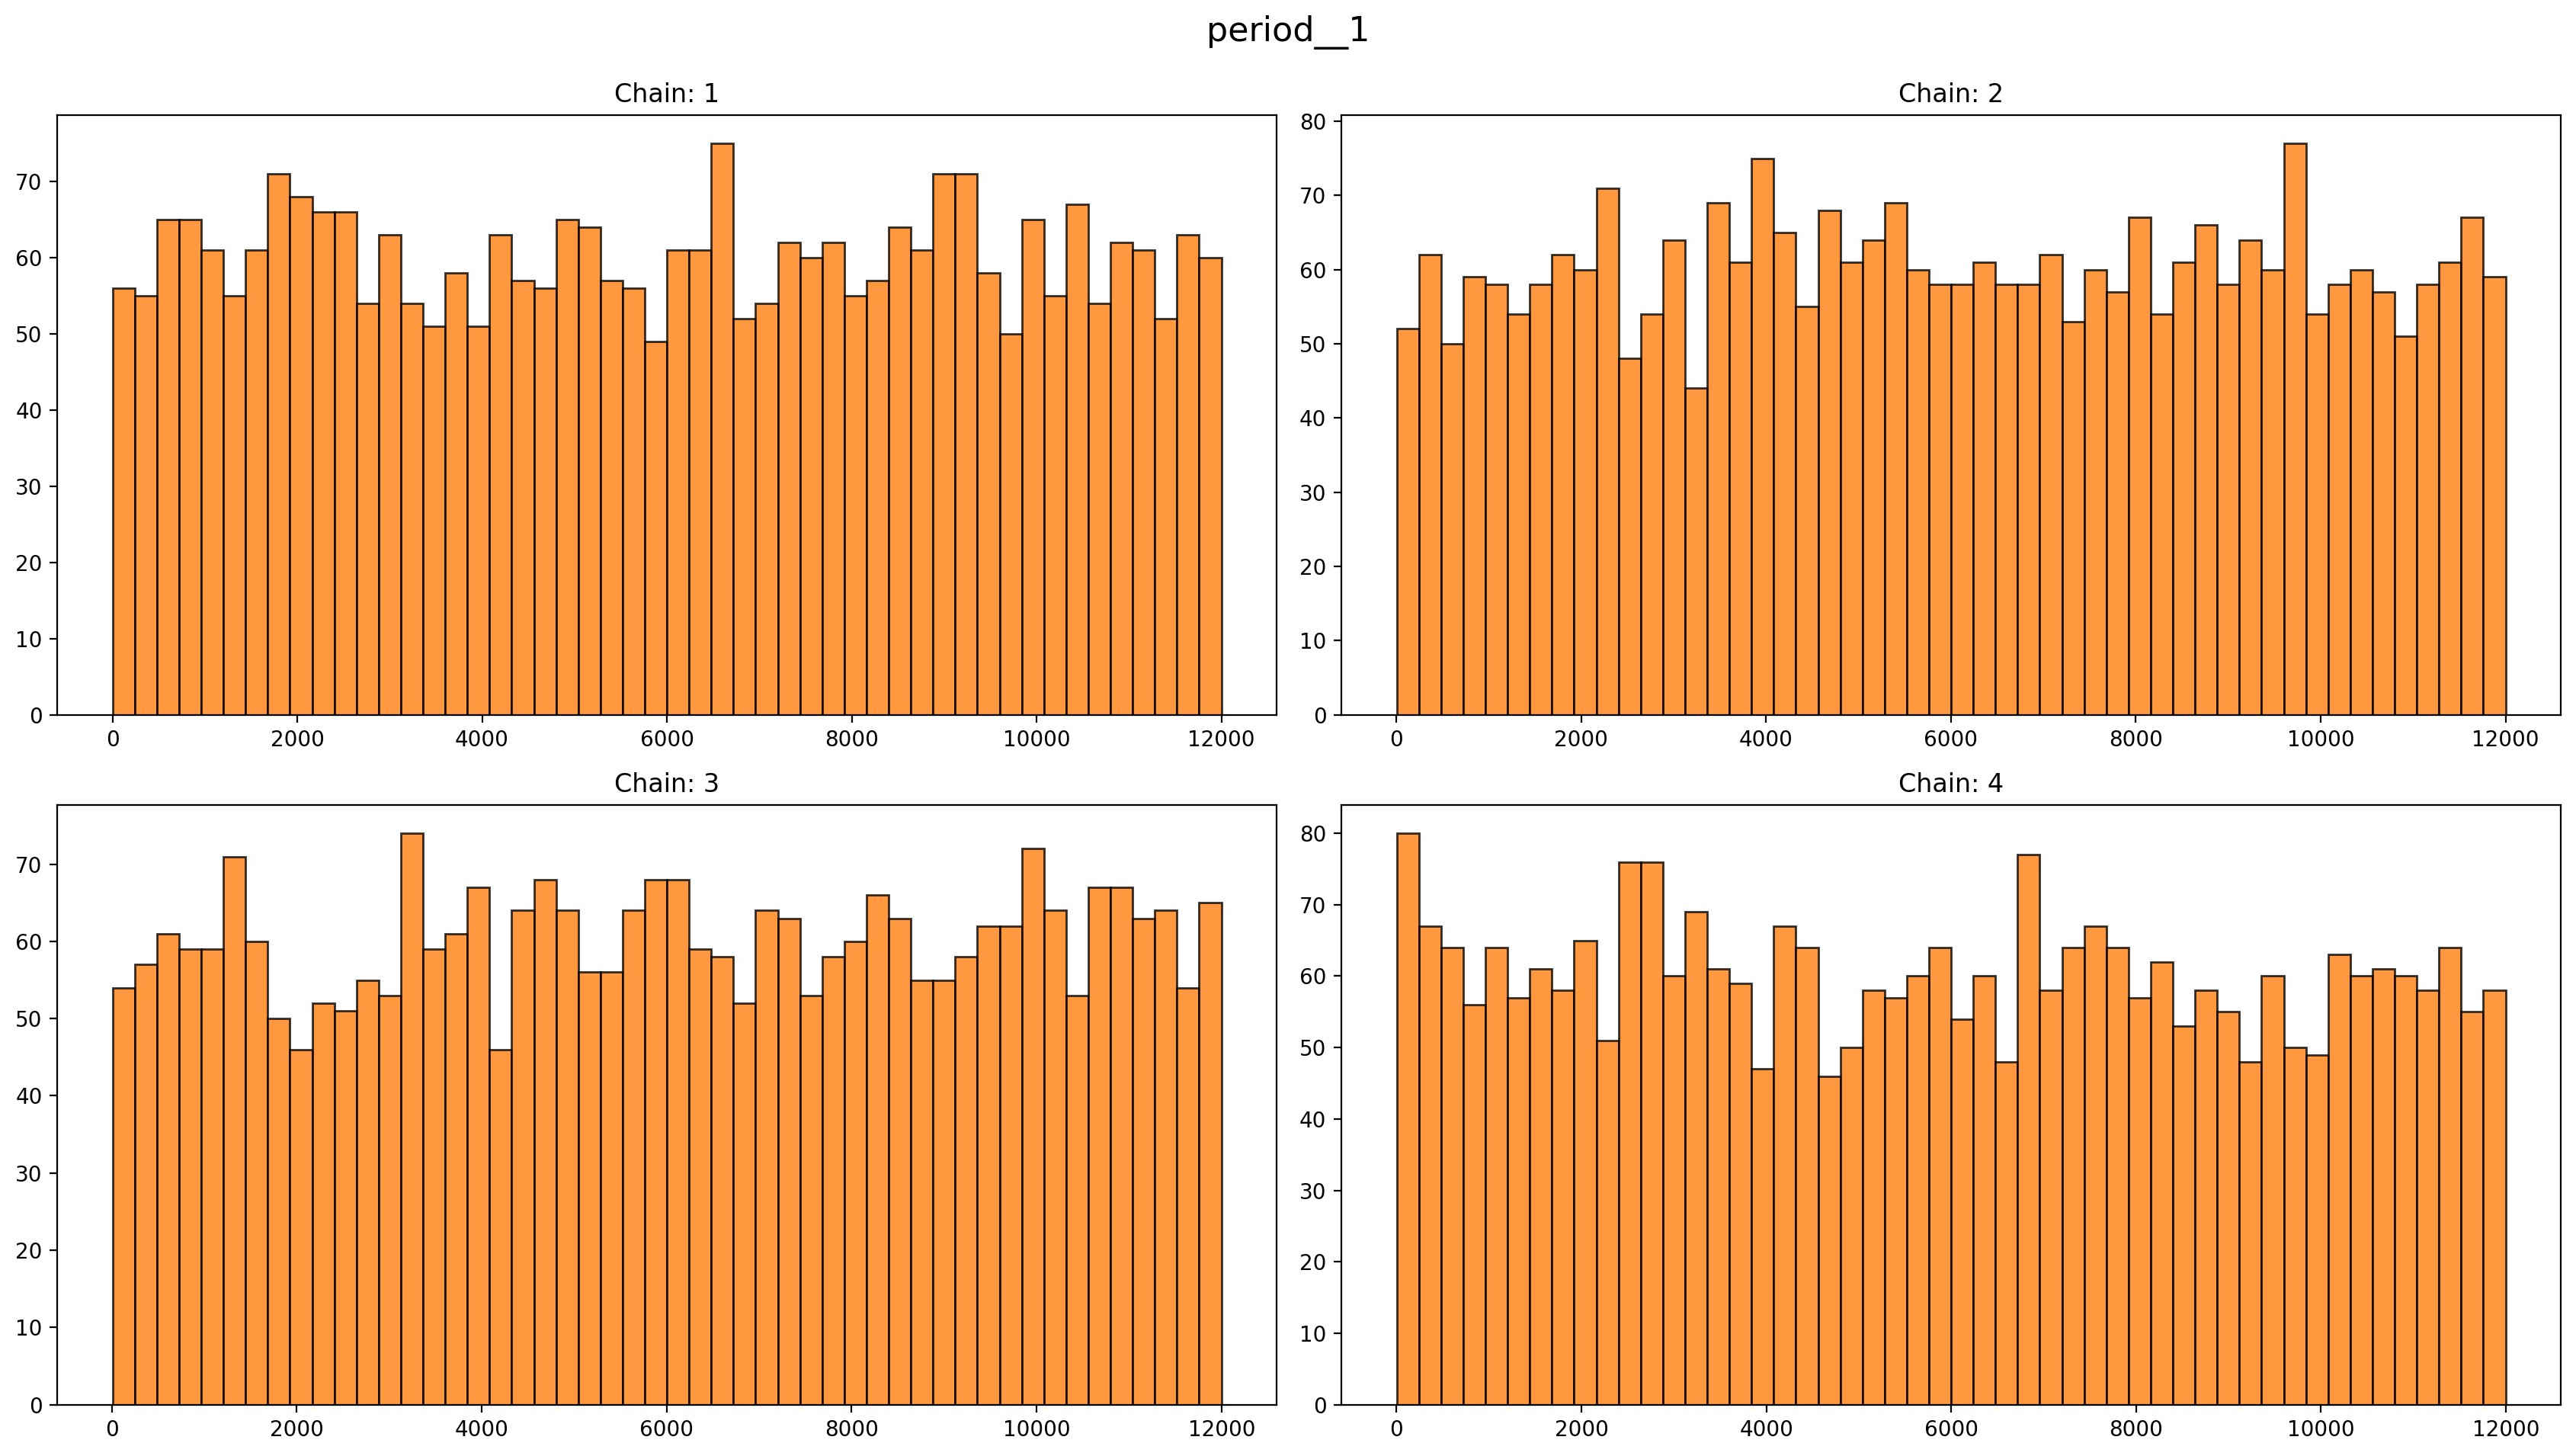

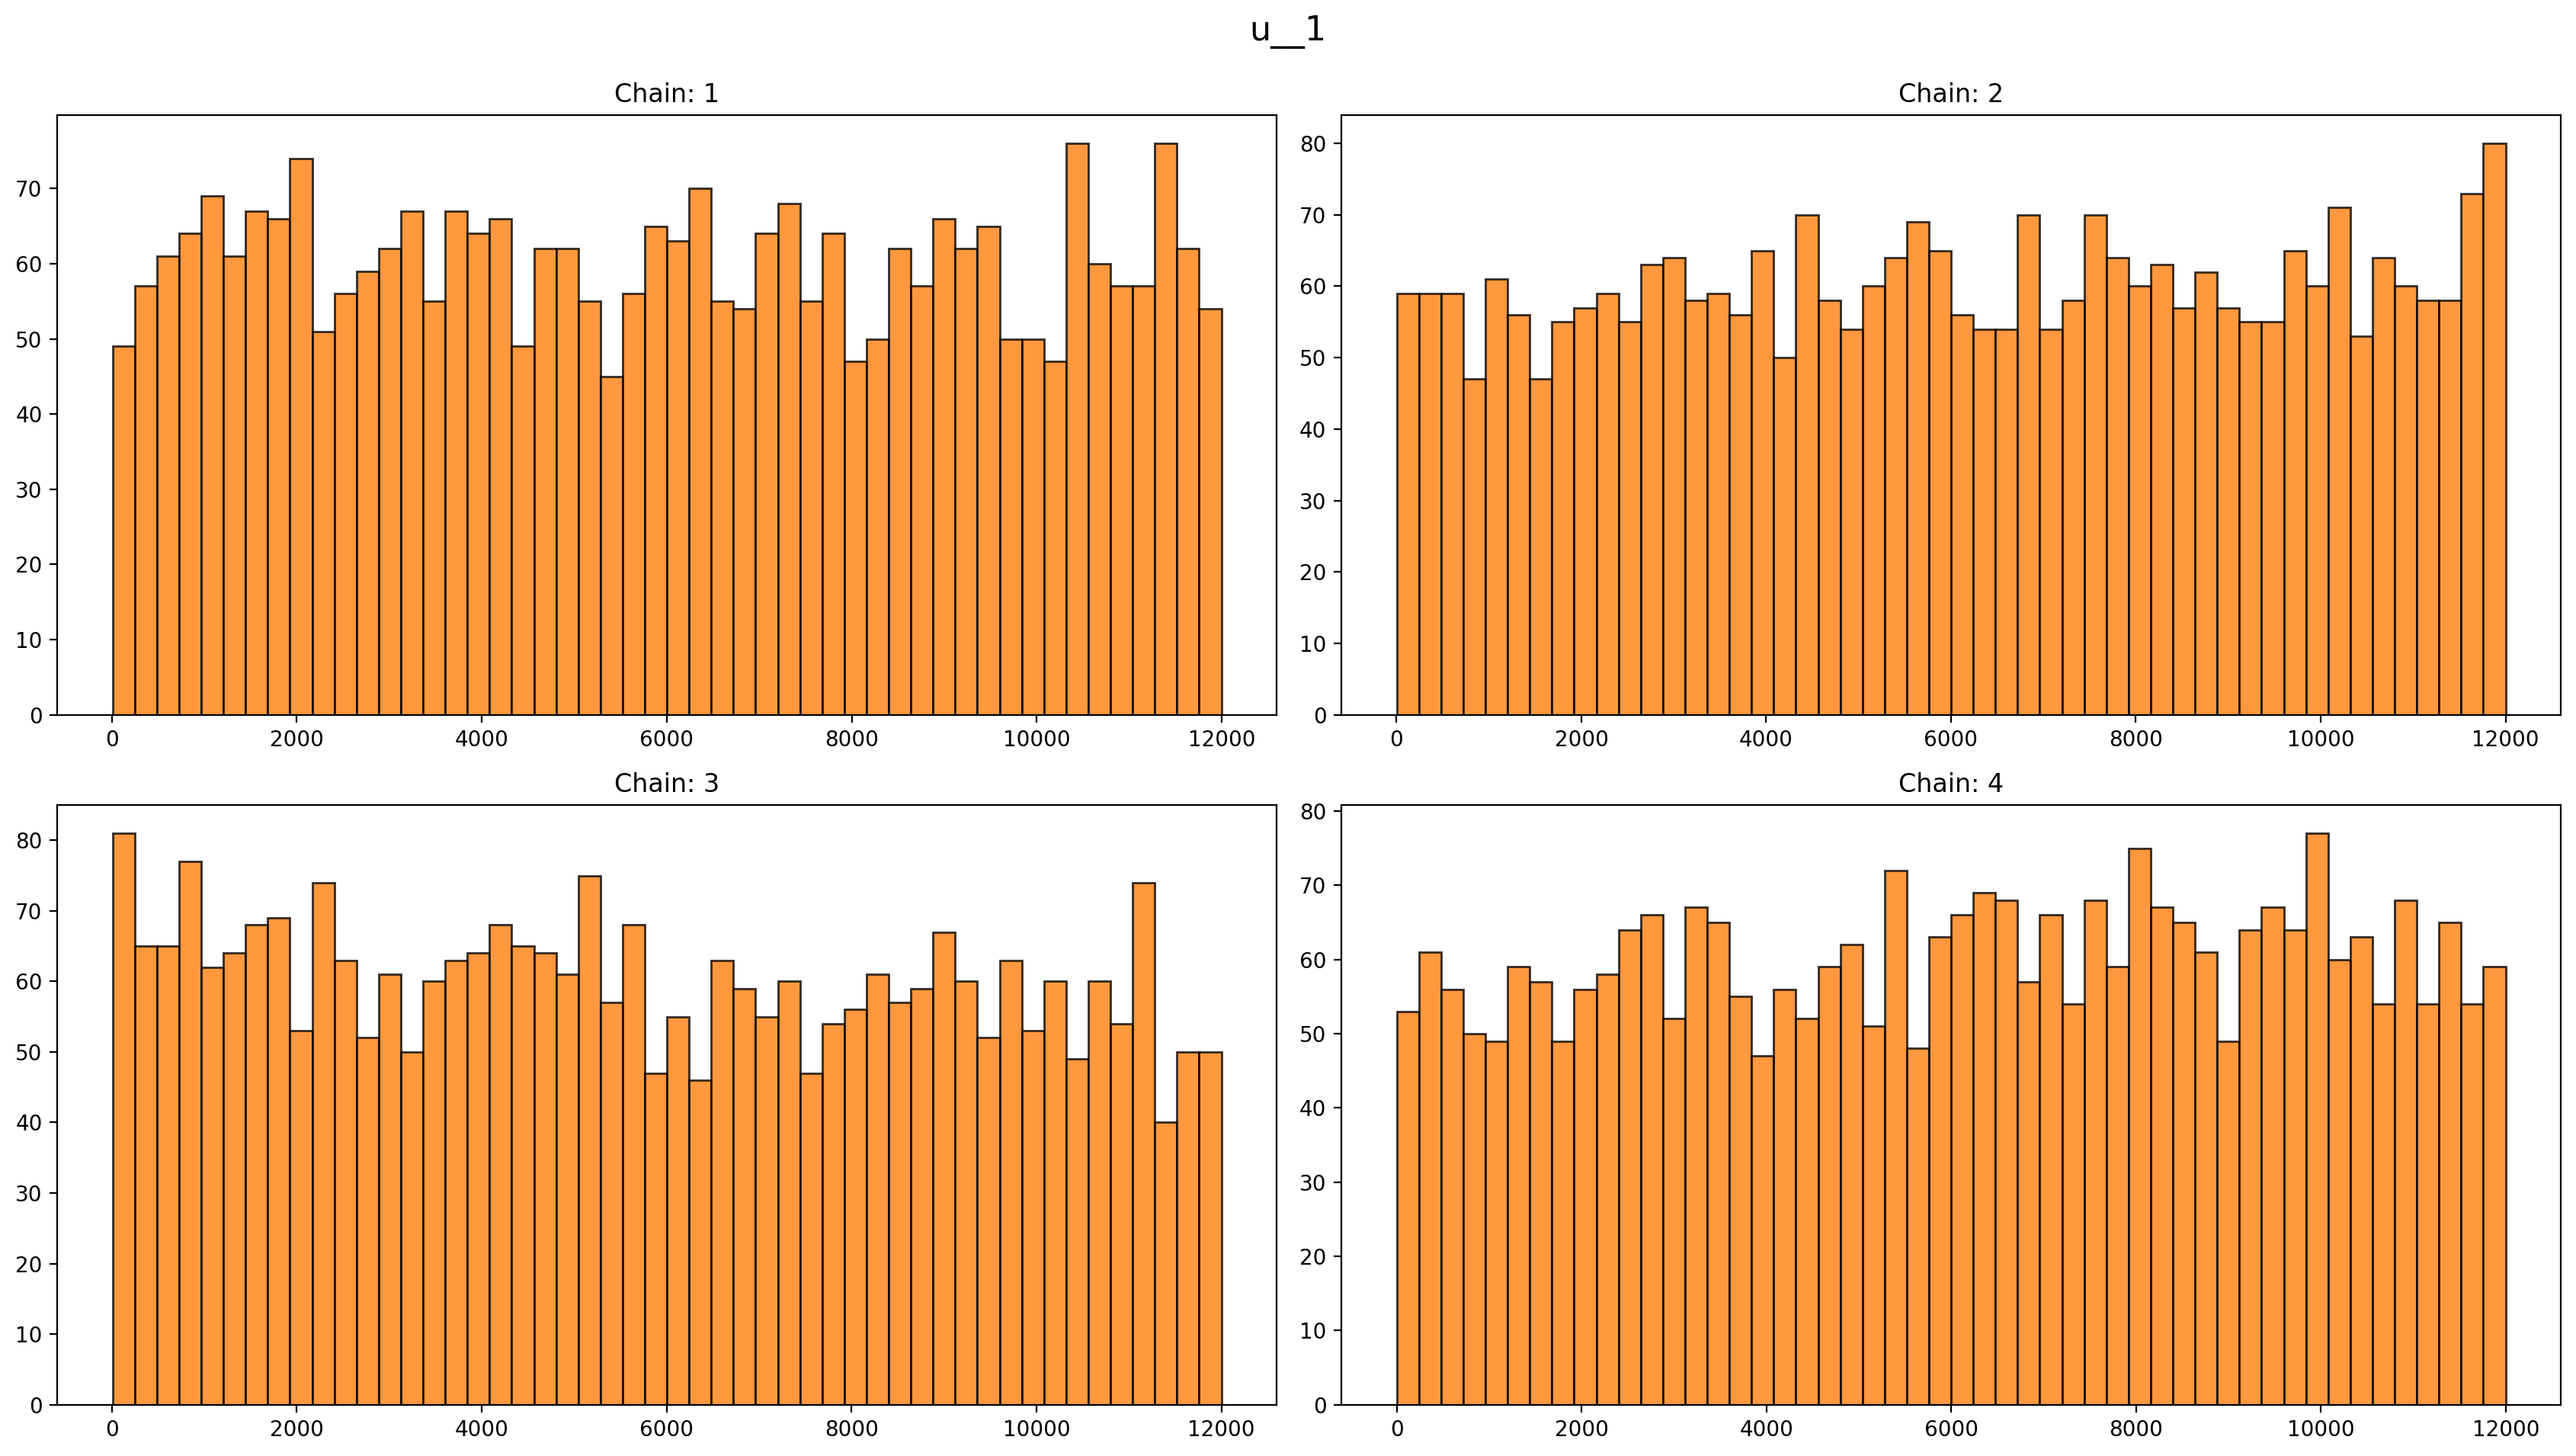

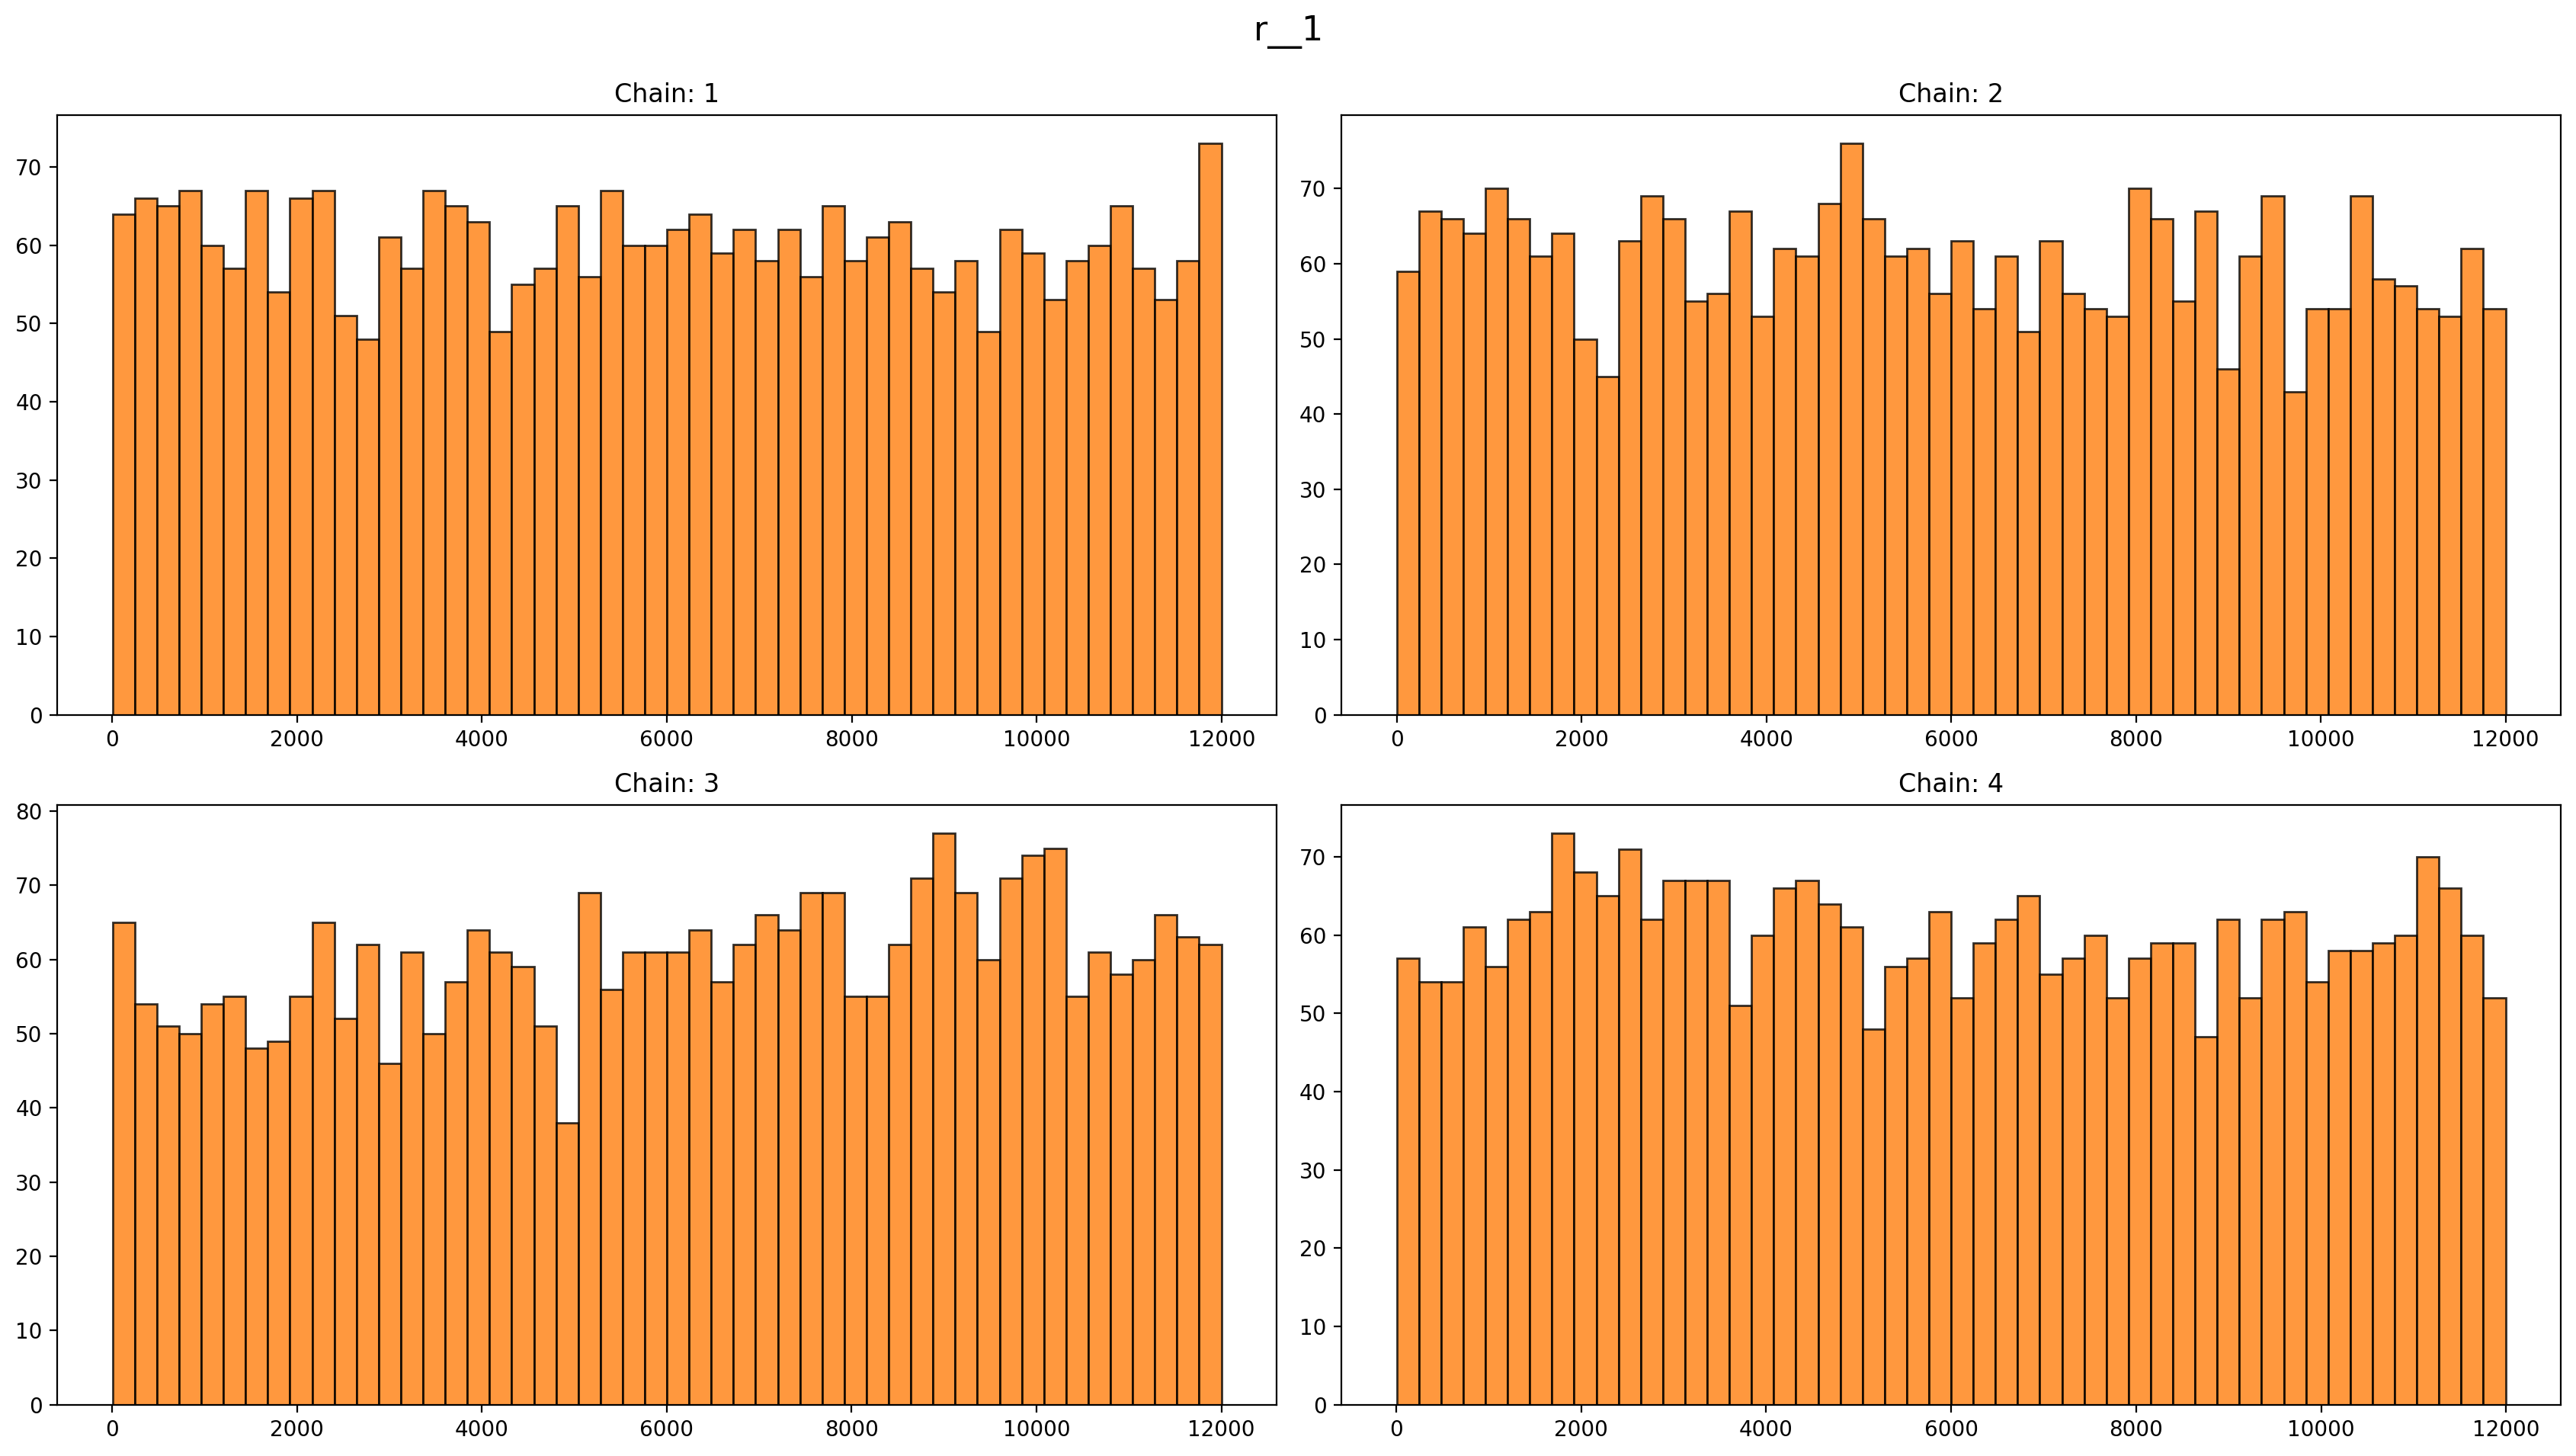

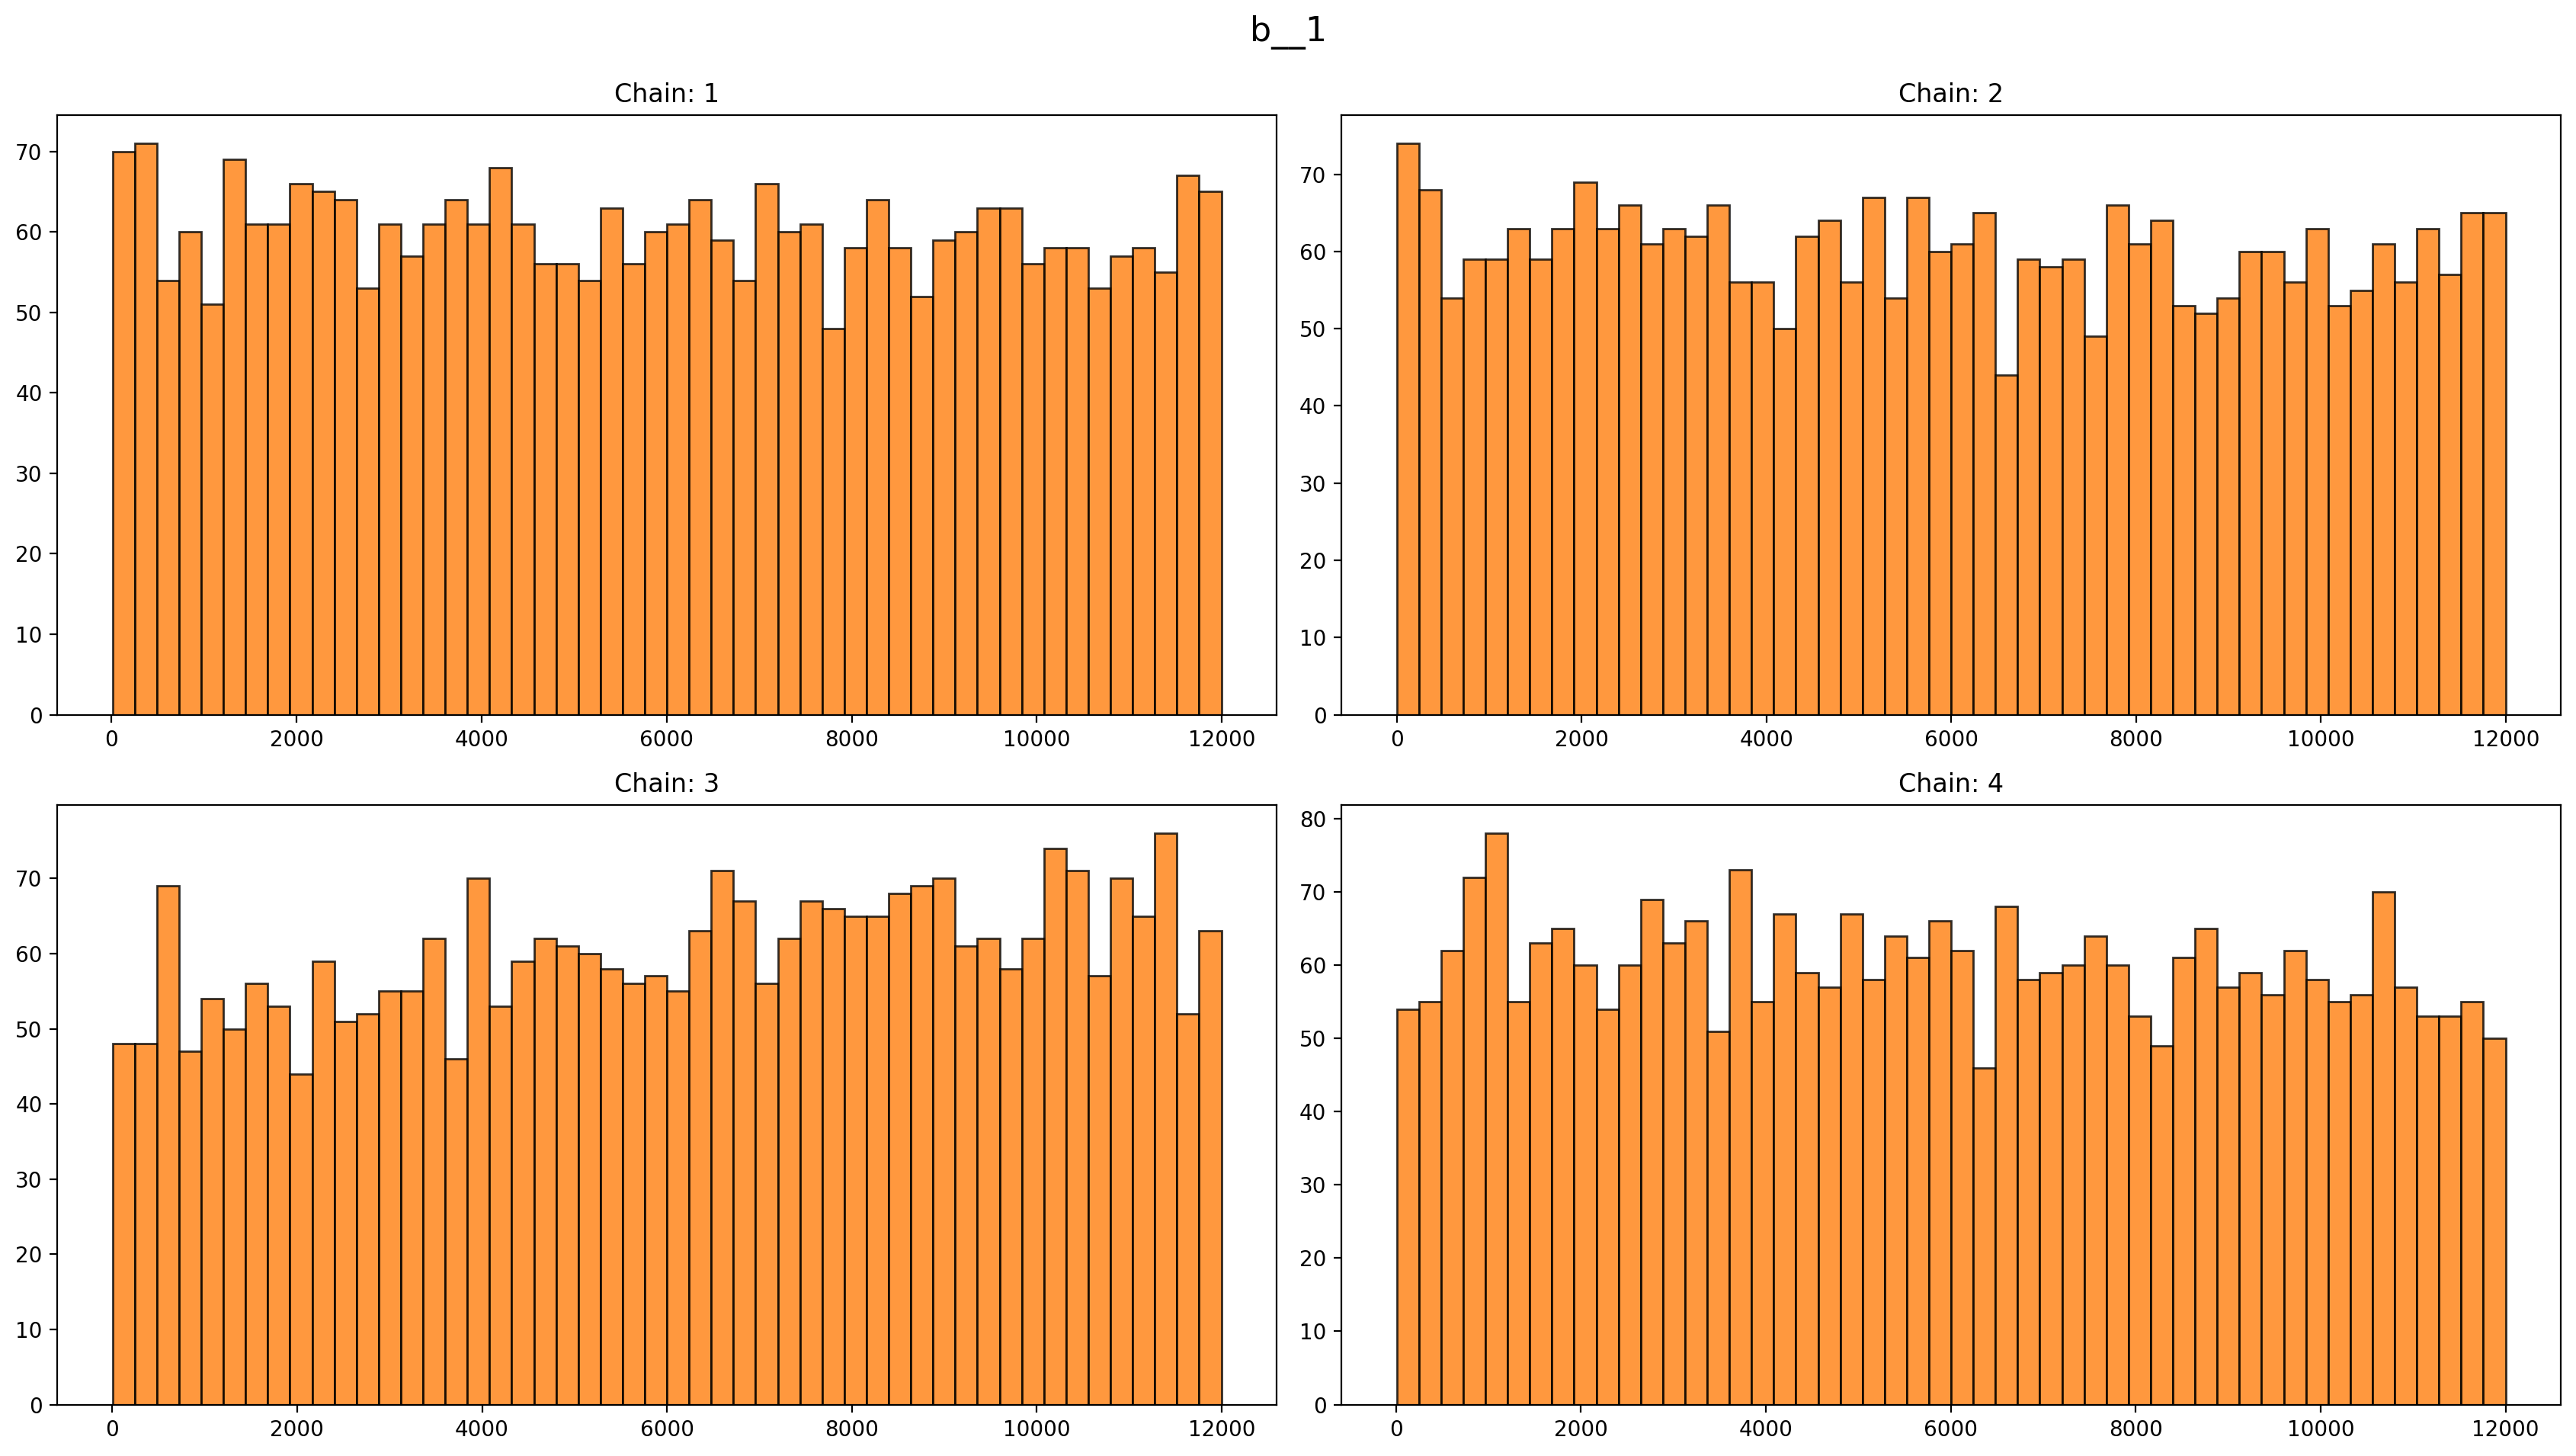

In [14]:
print("planet 1")
for param_name, param_chains in planet_1_params_dict.items():
    plotutils.rankplot(param_chains, 4, 2, 2, title=param_name,
                      hist_kwargs={"color":"C0"})
print("\nplanet 2")
for param_name, param_chains in planet_2_params_dict.items():
    plotutils.rankplot(param_chains, 4, 2, 2, title=param_name,
                      hist_kwargs={"color":"C1"})

## Phase plots

Finally, we can plot the phase folded light curve of each planet for future scientific analysis, with more confidence that our sampler has converged.

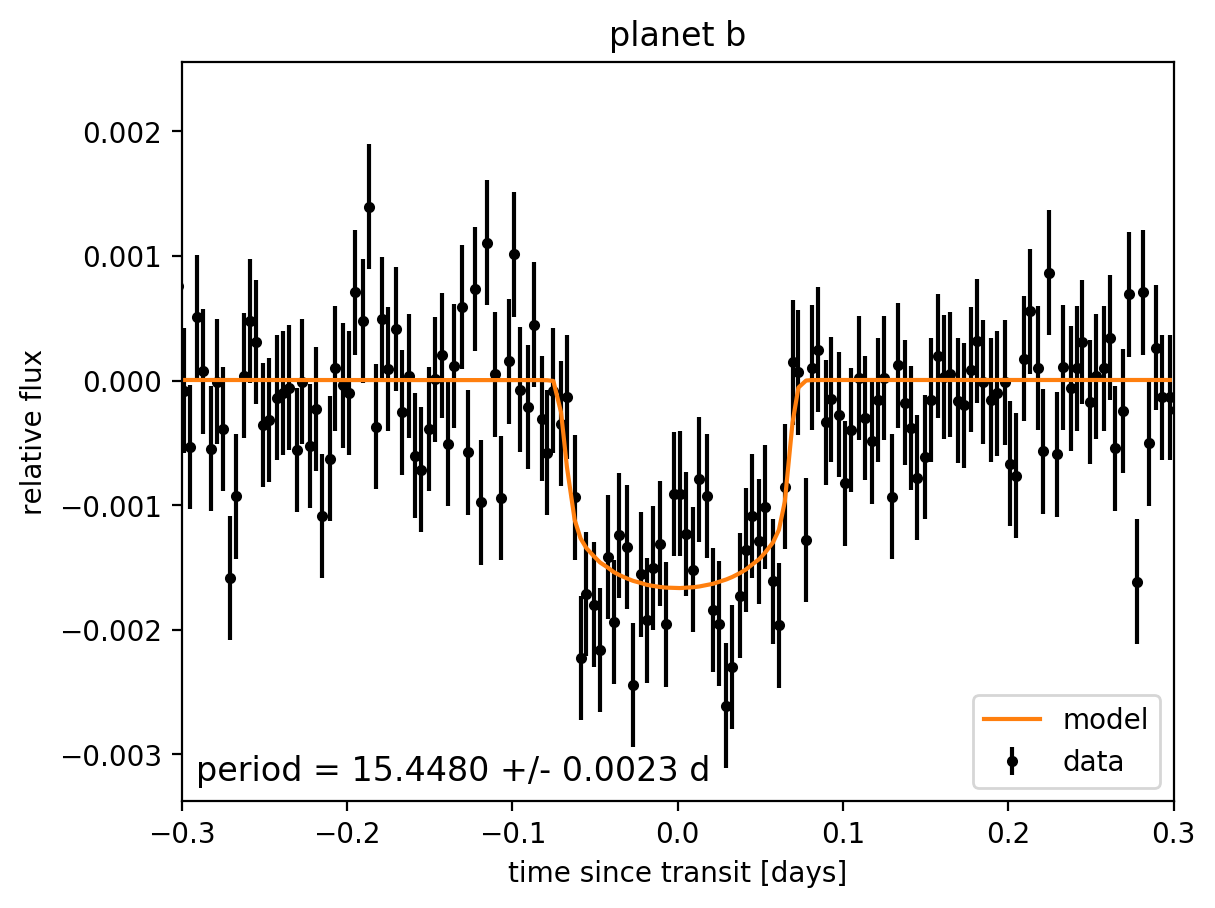

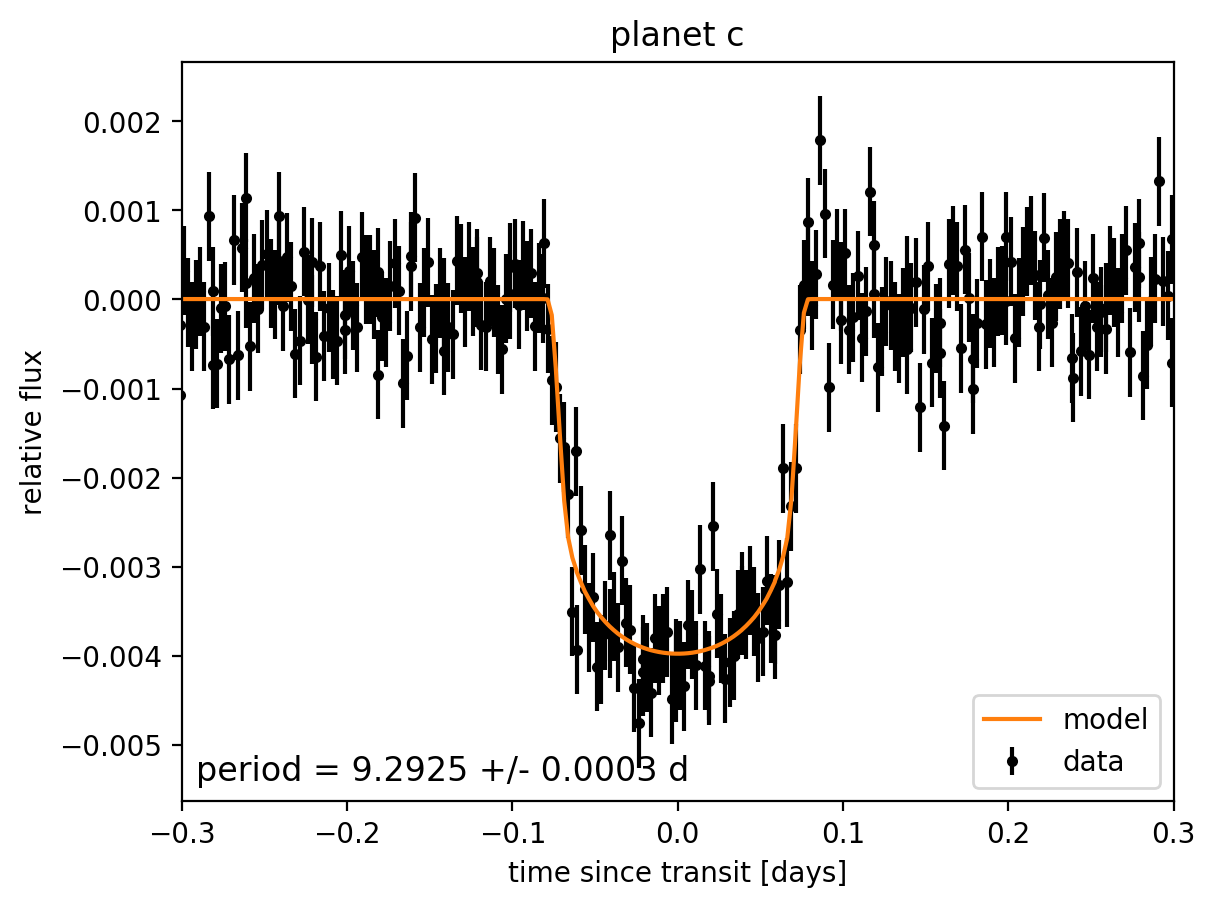

In [15]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)
print("\n".join(bib.splitlines()[:10]) + "\n...")

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.

@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
